# Импорты

In [1]:
import time
import sys
import warnings
from pathlib import Path
from typing import Sequence, Union
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from functools import partial
import dill
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.model_selection import (
    train_test_split, GridSearchCV, StratifiedKFold)
from sklearn.metrics import (
    roc_auc_score, accuracy_score, confusion_matrix, precision_score, 
    recall_score, f1_score, make_scorer, roc_curve)
from sklearn.pipeline import Pipeline
from feature_engine.encoding import RareLabelEncoder, OneHotEncoder
from feature_engine.wrappers import SklearnTransformerWrapper
from feature_engine.outliers import Winsorizer
from feature_engine.selection import (
    DropDuplicateFeatures, DropConstantFeatures, 
    DropCorrelatedFeatures, DropFeatures)
from feature_engine.transformation import YeoJohnsonTransformer
from bayes_opt import BayesianOptimization

# модели
from sklearn.base import BaseEstimator
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, HistGradientBoostingClassifier)
from xgboost import XGBClassifier

Дополнительные данные

In [2]:
russian_holidays = [
    '2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04', '2021-01-05', 
    '2021-01-06', '2021-01-07', '2021-01-08', '2021-02-22', '2021-02-23', 
    '2021-03-08', '2021-05-01', '2021-05-03', '2021-05-09', '2021-05-10', 
    '2021-06-12', '2021-06-14', '2021-11-04', '2021-11-05', '2021-12-31', 
    '2022-01-01', '2022-01-02', '2022-01-03', '2022-01-04', '2022-01-05', 
    '2022-01-06', '2022-01-07', '2022-01-08', '2022-02-23', '2022-03-08', 
    '2022-05-01', '2022-05-02', '2022-05-09', '2022-06-12', '2022-06-13', 
    '2022-11-04', '2022-12-31']

organic_mediums = ['organic', 'referral', '(none)']

social_media_sources = ['QxAxdyPLuQMEcrdZWdWb', 'MvfHsxITijuriZxsqZqt', 
                        'ISrKoXQCxqqYvAZICvjs', 'IZEXUFLARCUMynmHNBGo', 
                        'PlbkrSYoHuZBWfYjYnfw', 'gVRrcxiDQubJiljoTbGm']

# Исходные данные

In [3]:
df_hits = pd.read_csv("D:\Final_Work\data\ga_hits.csv", encoding='utf-8')

In [4]:
df_hits.head()

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,NaN
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,NaN
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,NaN
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,NaN
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,NaN


In [5]:
df_hits.shape

(15726470, 11)

In [6]:
df_sessions = pd.read_csv("D:\Final_Work\data\ga_sessions.csv", low_memory=False)

In [7]:
df_sessions.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow


In [8]:
df_sessions.shape

(1860042, 18)

In [9]:
df_hits.describe(include='all')

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
count,15726470,15726470,6.566148e+06,1.572647e+07,15726470,9451666,15726470,15726470,15726470,11966286,0.0
unique,1734610,226,NaN,NaN,1,37873,342715,52,230,39825,NaN
top,5442565791571325612.1632449195.1632449195,2021-05-24,NaN,NaN,event,HbolMJUevblAbkHClEQa,podpiska.sberauto.com/,card_web,view_card,KclpemfoHstknWHFiLit,NaN
freq,768,513035,NaN,NaN,15726470,8879187,2793639,7456998,3558985,6505447,NaN
mean,NaN,NaN,2.091050e+05,2.356715e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,4.032110e+05,2.887713e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,0.000000e+00,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,2.412000e+04,7.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,8.994100e+04,1.500000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,2.195352e+05,2.900000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df_sessions.describe(include='all')

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
count,1860042,1860042,1860042,1860042,1.860042e+06,1859945,1860042,1640439,1524427,777981,1860042,789904,1492864,16338,1860042,1860042,1860042,1860042
unique,1860042,1391719,226,85318,NaN,293,56,412,286,1219,3,13,205,104,5039,57,166,2548
top,9055434745589932991.1637753792.1637753792,1750498477.1629450062,2021-05-24,12:00:00,NaN,ZpYIoDJMcFzVoPFsHGJL,banner,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Apple,AuMdmADEIoPXiWpTsBEj,414x896,Chrome,Russia,Moscow
freq,1,462,39453,61067,NaN,578290,552272,463481,1006599,506819,1474871,464054,551088,9778,169090,1013436,1800565,805329
mean,NaN,NaN,NaN,NaN,2.712804e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,1.182907e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,2.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df_hits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15726470 entries, 0 to 15726469
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   session_id      object 
 1   hit_date        object 
 2   hit_time        float64
 3   hit_number      int64  
 4   hit_type        object 
 5   hit_referer     object 
 6   hit_page_path   object 
 7   event_category  object 
 8   event_action    object 
 9   event_label     object 
 10  event_value     float64
dtypes: float64(2), int64(1), object(8)
memory usage: 1.3+ GB


In [12]:
df_hits.isna().sum()

session_id               0
hit_date                 0
hit_time           9160322
hit_number               0
hit_type                 0
hit_referer        6274804
hit_page_path            0
event_category           0
event_action             0
event_label        3760184
event_value       15726470
dtype: int64

In [13]:
df_sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 18 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   session_id                object
 1   client_id                 object
 2   visit_date                object
 3   visit_time                object
 4   visit_number              int64 
 5   utm_source                object
 6   utm_medium                object
 7   utm_campaign              object
 8   utm_adcontent             object
 9   utm_keyword               object
 10  device_category           object
 11  device_os                 object
 12  device_brand              object
 13  device_model              object
 14  device_screen_resolution  object
 15  device_browser            object
 16  geo_country               object
 17  geo_city                  object
dtypes: int64(1), object(17)
memory usage: 255.4+ MB


In [14]:
df_sessions.isna().sum()

session_id                        0
client_id                         0
visit_date                        0
visit_time                        0
visit_number                      0
utm_source                       97
utm_medium                        0
utm_campaign                 219603
utm_adcontent                335615
utm_keyword                 1082061
device_category                   0
device_os                   1070138
device_brand                 367178
device_model                1843704
device_screen_resolution          0
device_browser                    0
geo_country                       0
geo_city                          0
dtype: int64

In [15]:
print(f'Количество дубликатов в дата-сете df_hits: {df_hits.duplicated().sum()}')

Количество дубликатов в дата-сете df_hits: 0


In [16]:
print(f'Количество дубликатов в дата-сете df_sessions: {df_sessions.duplicated().sum()}')

Количество дубликатов в дата-сете df_sessions: 0


In [17]:
print(f'Временной период данных в датасете df_his находится в пределах с {df_hits.hit_date.min()} по {df_hits.hit_date.max()}') 
print(f'Временной период данных в датасете df_sessions находится в пределах с {df_sessions.visit_date.min()} по {df_sessions.visit_date.max()}')

Временной период данных в датасете df_his находится в пределах с 2021-05-19 по 2021-12-31
Временной период данных в датасете df_sessions находится в пределах с 2021-05-19 по 2021-12-31


## Предварительный вывод

Размер датасета df_hits сотавляет 15726470 строк на 11 колонок. Количетво дубликатов равно 0. Количество незаполненных значений по параметру hit_time составляет 9160322 ед., hit_referer составляет 6274804 ед., event_label составляет 3760184 ед. и event_value составляет 15726470 ед. Все данные находятся во временном интервале с 15.05.2021 по 31.12.2021 гг.

Размер датасета df_sessions составляет 1860042 строк на 18 колонок. Количество дубликатов равно 0. Количество незаполненных значений по параметру utm_source составляет 97 ед., по параметру utm_campaign составляет 219603 ед., по параметру utm_adcontent составляет 335615 ед., по параметру utm_keyword составляет 1082061 ед., по параметру device_os составляет 1070138 ед., по параметру device_brand составляет 37178 ед. и по параметру device_model составляет 1843704 ед.

# Анализ датасета df_hits

Целевые действия клиентов находятся в переменной event_actions. Рассмотрим все цеевые действия посетителей и количество уникальных значений:

In [18]:
df_hits.event_action.value_counts().head(15)

view_card                    3558985
view_new_card                3551009
sub_landing                  1798117
go_to_car_card                973666
sub_view_cars_click           791515
search_form_region            512069
search_form_search_btn        433748
sap_search_form_cost_to       356596
showed_number_ads             326274
pagination_click              248944
search_form_mark_select       222652
quiz_show                     214037
search_form_model_select      211890
sap_search_form_cost_from     188129
photos_all                    181493
Name: event_action, dtype: int64

In [19]:
print(f'Уникальных значений в целевых действиях {df_hits.event_action.nunique()} значений')

Уникальных значений в целевых действиях 230 значений


In [20]:
# Выведем, сколько всего целевых действий и их долю в общем количестве действий
all_targets = ['sub_car_claim_click',
               'sub_car_claim_submit_click',
               'sub_open_dialog_click',
               'sub_custom_question_submit_click',
               'sub_call_number_click',
               'sub_callback_submit_click',
               'sub_submit_success',
               'sub_car_request_submit_click']

sorted_all_targets = []
total = 0
labels, data = [], []

for targets_name in all_targets:
    
    value = len(df_hits[df_hits['event_action'] == targets_name])
    percent = round(value/len(df_hits)*100, 3)
    sorted_all_targets.append((targets_name, value, percent))
    
    total += value
    
sorted_all_targets = sorted(sorted_all_targets, key=lambda sorted_all_targets: sorted_all_targets[1],  reverse=True)
print(f'\n\nВсего целевых действий = {total} из {len(df_hits)} что составляет {total/len(df_hits)*100: .2f} %\n')
for target in sorted_all_targets:
    data.append(target[1])
    labels.append(target)
    print(target[0], '=', target[1], 'что составляет', target[2], '%') 



Всего целевых действий = 104908 из 15726470 что составляет  0.67 %

sub_car_claim_click = 37928 что составляет 0.241 %
sub_open_dialog_click = 25870 что составляет 0.164 %
sub_submit_success = 18439 что составляет 0.117 %
sub_car_claim_submit_click = 12359 что составляет 0.079 %
sub_call_number_click = 3653 что составляет 0.023 %
sub_callback_submit_click = 3074 что составляет 0.02 %
sub_car_request_submit_click = 2966 что составляет 0.019 %
sub_custom_question_submit_click = 619 что составляет 0.004 %


In [21]:
event_counts = df_hits['session_id'].value_counts() # рассчитаем количество событий в одну сессию
event_counts.head(5)

5442565791571325612.1632449195.1632449195    768
6568868914238486437.1632270313.1632270313    678
5959671972744778783.1632490527.1632490600    548
7452598043578978502.1632358598.1632358598    514
3070792010704358528.1629752408.1629752408    498
Name: session_id, dtype: int64

In [22]:
dates_max_events = df_hits.groupby(['session_id', 'hit_date']).count()
dates_max_events.sort_values(by='event_action', ascending=False)

,,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
session_id,hit_date,,,,,,,,,
5442565791571325612.1632449195.1632449195,2021-09-24,384,768,768,384,768,768,768,430,0
6568868914238486437.1632270313.1632270313,2021-09-22,339,678,678,339,678,678,678,439,0
5959671972744778783.1632490527.1632490600,2021-09-24,274,548,548,274,548,548,548,320,0
7452598043578978502.1632358598.1632358598,2021-09-23,257,514,514,257,514,514,514,257,0
3070792010704358528.1629752408.1629752408,2021-08-24,0,498,498,498,498,498,498,498,0
...,...,...,...,...,...,...,...,...,...,...
7332600372471986108.1628931928.1628931928,2021-08-14,0,1,1,1,1,1,1,1,0
7332600372471986108.1628929805.1628929805,2021-08-14,0,1,1,1,1,1,1,1,0
7332600372471986108.1628926536.1628926536,2021-08-14,0,1,1,1,1,1,1,1,0


In [23]:
# выведем частоту событий в одну сессию
d = pd.DataFrame(event_counts.value_counts())
d.reset_index(inplace= True)
d

,index,session_id
0,1,537243
1,2,237658
2,6,88086
3,3,85233
4,4,63603
...,...,...
346,304,1
347,302,1
348,296,1
349,295,1


In [24]:
df_hits.corr()

,hit_time,hit_number,event_value
hit_time,1.000000,0.605906,NaN
hit_number,0.605906,1.000000,NaN
event_value,NaN,NaN,NaN


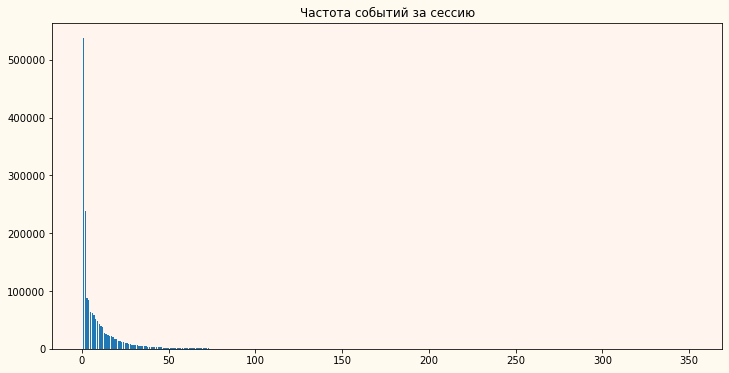

In [25]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(1, 352)
y = d['session_id']# 

fig, ax = plt.subplots()

ax.bar(x, y)
plt.title('Частота событий за сессию')
ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(12)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure

plt.show()

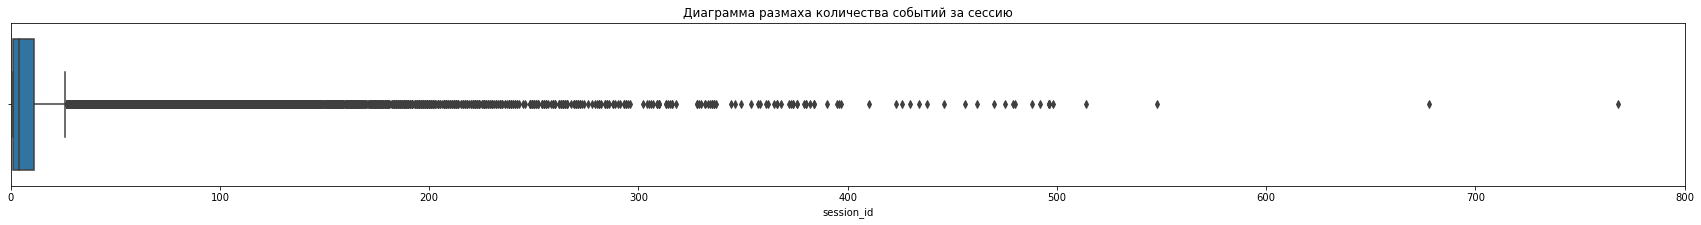

In [26]:
plt.figure(figsize=(30, 3))
plt.title('Диаграмма размаха количества событий за сессию')
plt.xlim(0, 800)
sns.boxplot(x=event_counts);

# Дополнение датасета df_session целевой переменной

Дополним датасет новым столбцом `target`, куда запишем целевые события, которые возьмем из  переменной `event_action`. Целевую переменную считаем положительной, если за сессию состоялось хотя бы одно из целевых событий. Для тех сессий в `session`, для которых не нашлось ни одного события в `df_hits`, целевую переменную заполняем значением `0`.

In [27]:
df_hits['target'] = df_hits['event_action'].isin(all_targets) # заполняет столбец df_hits['target'] 'True', если df_hits['event_action'] содержит целевую
target = df_hits.groupby('session_id')['target'].any() # target группирует по id (session_id) и по столбцу 'target', то есть все одинаковые session_id собираются
df_sessions = df_sessions.join(target, on='session_id') # добавляем к df_session target

In [28]:
df_sessions.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,target
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust,False
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow,False
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk,False
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,False
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,False


In [29]:
def as_percent(x: float) -> str:
    """Используется для преобразования доли в процент (в виде строки)."""
    
    return f'{x:0.2%}'

print('Распределение целевой переменной:')
df_sessions["target"].value_counts(dropna=False, normalize=True).apply(as_percent)

Распределение целевой переменной:


False    90.43%
NaN       6.87%
True      2.70%
Name: target, dtype: object

Только 2,7% всех активностей пользователей закончились каким-либо целевым действием.

In [30]:
df_sessions['target'] = df_sessions['target'].fillna(False).astype(int) # заполним Nan как False (не целевое действие) и все закодируем в '0' и '1' 

In [31]:
df_sessions["target"].value_counts(dropna=False, normalize=True).apply(as_percent)

0    97.30%
1     2.70%
Name: target, dtype: object

In [32]:
df_hits['target'].value_counts()

False    15621562
True       104908
Name: target, dtype: int64

Всего целевых действий 104,9 тыс. ед., нецелевых активнотей 1562,1 тыс. ед.

# Анализ датасета df_sessions 

## Анализ переменной sessions_id

In [33]:
all_unique = df_sessions['session_id'].nunique()
print(f'Все значения колонки `session_id` уникальны: {all_unique}')

Все значения колонки `session_id` уникальны: 1860042


## Анализ переменной client_id

In [34]:
print(f'Доля уникальных значений в `client_id`: '
      f'{df_sessions["client_id"].nunique()/len(df_sessions)*100:.2f}% от общего количества.')

Доля уникальных значений в `client_id`: 74.82% от общего количества.


## Анализ переменной visit_date  

In [35]:
df_sessions['visit_date'] = pd.to_datetime(df_sessions['visit_date']) # переведем данные столбца в формат даты
n_unique = df_sessions['visit_date'].nunique()
print(f'Количество уникальных значений в `visit_date`: {n_unique} ед.')

Количество уникальных значений в `visit_date`: 226 ед.


In [36]:
df_sessions['visit_date'].describe(datetime_is_numeric=True) # детальное описание

count                          1860042
mean     2021-09-26 11:45:55.389394176
min                2021-05-19 00:00:00
25%                2021-08-02 00:00:00
50%                2021-10-06 00:00:00
75%                2021-11-23 00:00:00
max                2021-12-31 00:00:00
Name: visit_date, dtype: object

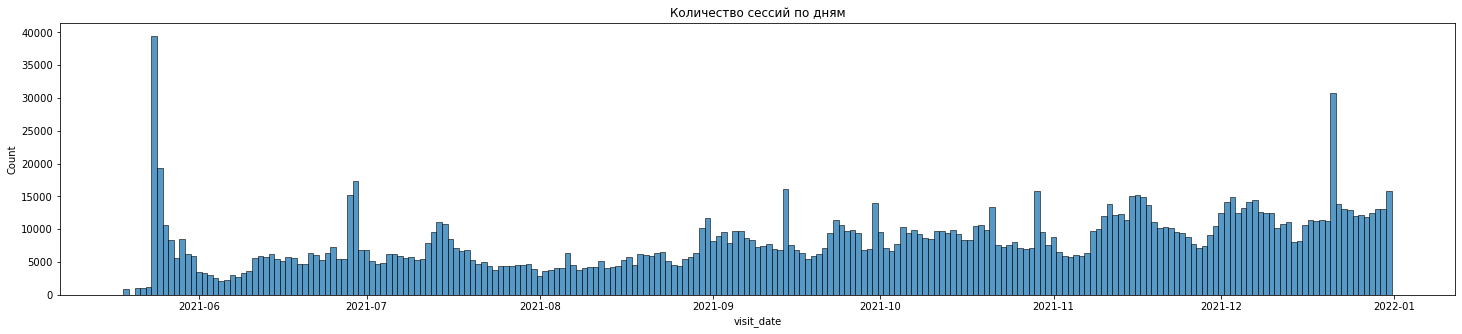

In [37]:
plt.figure(figsize=(25, 5))
sns.histplot(df_sessions, x='visit_date', discrete=True)
plt.title('Количество сессий по дням');

Судя по графику в анализируемом периоде наблюдается рост посещений сервиса, что говорит о заинтересованности потребителей

In [38]:
df_sessions['visit_date_weekday'] = df_sessions['visit_date'].dt.day_of_week # создаемновый признак "день недели" из даты визита

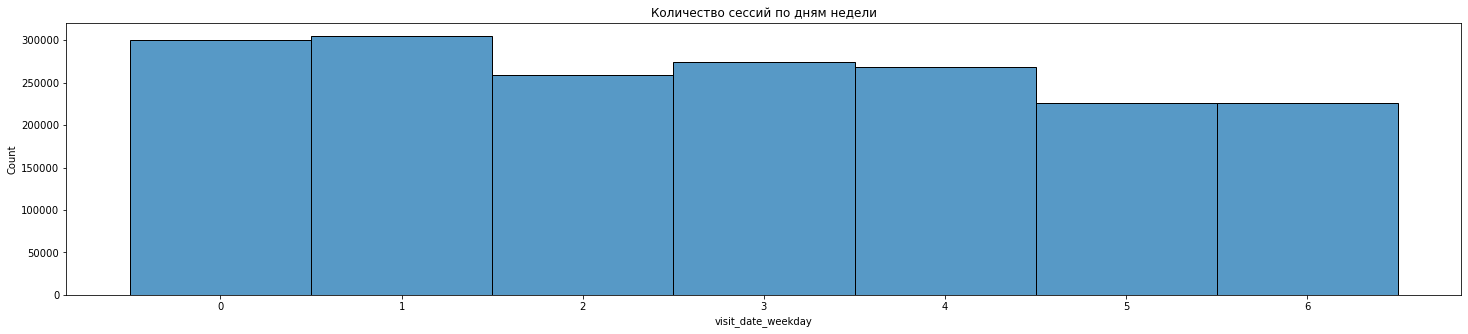

In [39]:
plt.figure(figsize=(25, 5))
sns.histplot(data=df_sessions, x='visit_date_weekday', discrete=True)
plt.title('Количество сессий по дням недели');

In [40]:
# Функция определения процента целевых действий
def target_percentage(
    data: pd.DataFrame, 
    column: str, 
    index_name: str = '',
    only_target: bool = False, 
    sort: bool = True, 
    percent: bool = True 
) -> Union[pd.DataFrame, pd.Series]:
    """Возвращает в удобном виде процент целевых действий (`target`==1) 
    по значениям заданной колонки `column`."""

    # вводим названия колонок
    count = 'Количество объектов'
    ratio = 'Доля от общего числа'
    target = 'Процент целевых действий'

    groupby = data.groupby(column)  # разбиваем по значениям
    
    # расчёт количества объектов и доли целевых действий
    result = pd.DataFrame(index=groupby.groups)
    result[count] = groupby[column].count()
    result[ratio] = result[count] / len(data)
    result[target] = groupby['target'].sum() / result[count]
    
    # форматирование выходной таблицы
    result.index.name = index_name or column
    if sort: result = result.sort_values(target, ascending=False)
    if percent: 
        result[target] = result[target].apply(as_percent)
        result[ratio] = result[ratio].apply(as_percent)
    
    # вывод результата результатов
    if only_target: 
        return result[target].rename('target_percentage')
    return result

In [41]:
print('Процент целевых действий по дням недели составляет:')
target_percentage(df_sessions, 'visit_date_weekday', index_name='День недели')

Процент целевых действий по дням недели составляет:


,Количество объектов,Доля от общего числа,Процент целевых действий
День недели,,,
0,300906,16.18%,3.15%
1,305130,16.40%,2.84%
2,258616,13.90%,2.81%
3,274462,14.76%,2.63%
5,226397,12.17%,2.46%
6,225712,12.13%,2.45%
4,268819,14.45%,2.44%


Наибольший процент целевых дейсвий совершается в первой половине ннедели (с понедельника -0 по среду-2)

### Проанализируем количество посещений по выходным дням. Создадим новый признак, говорящий о выходном дне `visit_date_weekend`.

In [42]:
df_sessions['visit_date_weekend'] = df_sessions['visit_date_weekday'] > 4 # присвоим "True" выходным (суббота и воскресенье) 5, 6 > 4
print('Процент целевых действий по выходным дням составляет:')
target_percentage(df_sessions, 'visit_date_weekend', index_name='Выходной')

Процент целевых действий по выходным дням составляет:


,Количество объектов,Доля от общего числа,Процент целевых действий
Выходной,,,
False,1407933,75.69%,2.78%
True,452109,24.31%,2.46%


### Проанализируем посещения по дням в месяце. Дополнительно создадим новый признак - день месяца `visit_date_day`.

In [43]:
df_sessions['visit_date_day'] = df_sessions['visit_date'].dt.day # заполняет столбец днем месяца из даты

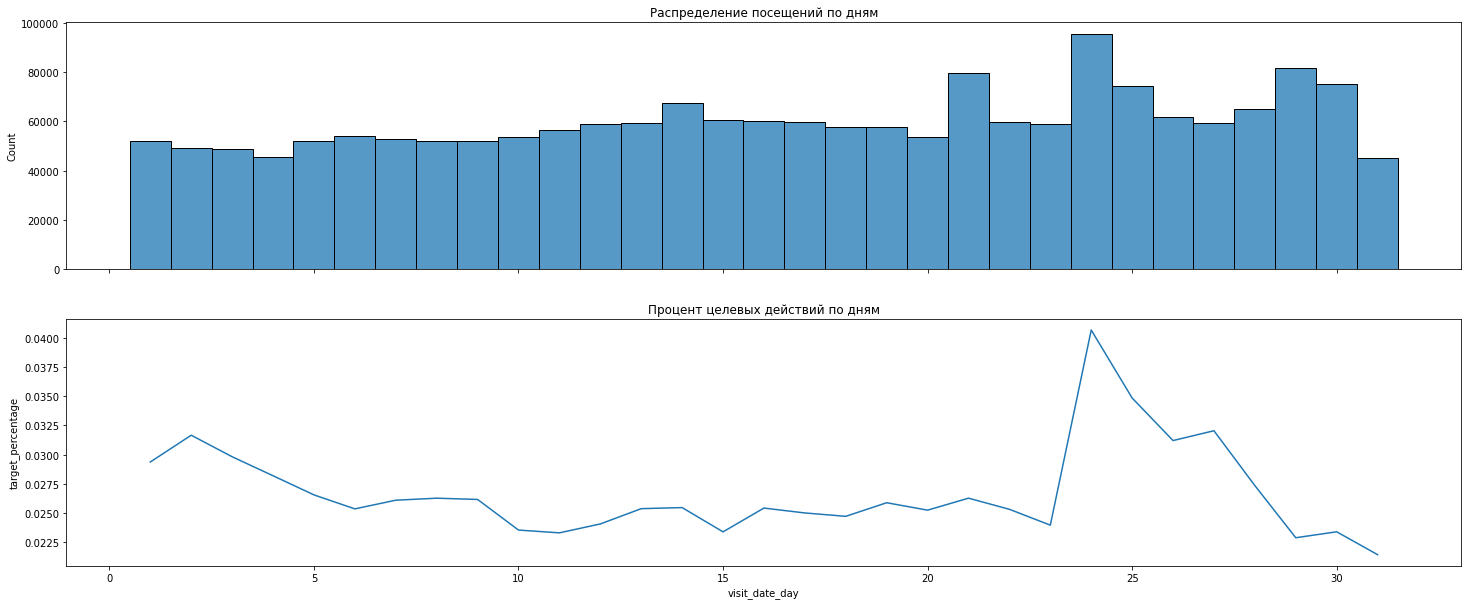

In [44]:
_, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(25, 10))

ax1.set_title('Распределение посещений по дням')
sns.histplot(data=df_sessions, x='visit_date_day', discrete=True, ax=ax1)

target_by_day = target_percentage(df_sessions, 'visit_date_day', 
                                  percent=False, only_target=True)
ax2.set_title('Процент целевых действий по дням')
sns.lineplot(data=target_by_day, ax=ax2);

### Рассмотрим влияние праздников на количество посещений и создадим этот признак `visit_date_holiday`.

In [45]:
#df_sessions['visit_date_holiday'] = df_sessions['visit_date'].isin(russian_holidays)
#print('Распределение праздничных дней:')
#target_percentage(df_sessions, 'visit_date_holiday', index_name='Праздник')

###  Рассморим влияние времени визита на целевое действие - переменная `visit_time`

In [46]:
df_sessions['visit_time'] = pd.to_datetime(df_sessions['visit_time'])

In [47]:
df_sessions['visit_time'].describe(datetime_is_numeric=True)

count                          1860042
mean     2023-07-17 13:49:53.502091008
min                2023-07-17 00:00:00
25%                2023-07-17 10:00:00
50%                2023-07-17 14:09:06
75%                2023-07-17 19:00:00
max                2023-07-17 23:59:59
Name: visit_time, dtype: object

### Рассмотрим влияние времени (часы) на целевое дейсвие. для этого введем новый признак - количество посещений по часам `visit_time_hour`.

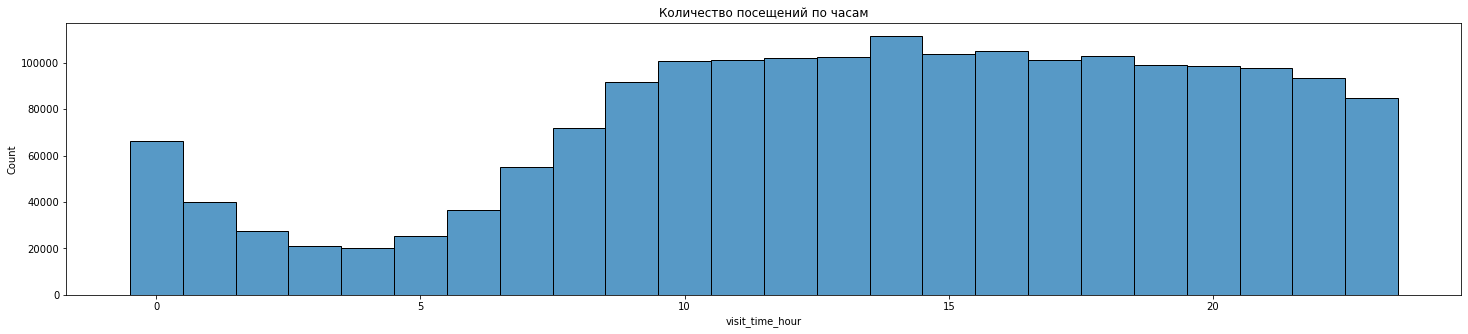

In [48]:
df_sessions['visit_time_hour'] = df_sessions['visit_time'].dt.hour
plt.figure(figsize=(25, 5))
sns.histplot(data=df_sessions, x='visit_time_hour', discrete=True)
plt.title('Количество посещений по часам');

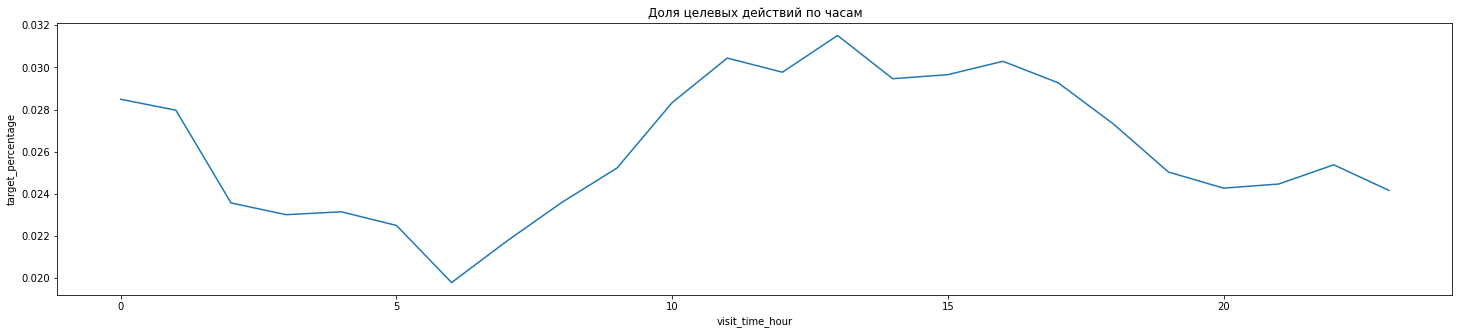

In [49]:
plt.figure(figsize=(25, 5))
target_by_hour = target_percentage(df_sessions, 'visit_time_hour', 
                                   percent=False, only_target=True)
sns.lineplot(data=target_by_hour)
plt.title('Доля целевых действий по часам');

Полученые результаты свидельствуют о том, что наибольшее количество посещений было совершено в промежуток времени с 10.00 до 20.00. 
Наибольшее количество целевых действий приходится на период с 11.00 до 17.00 - пик целевых действий с 13.00 до 14.00.
Для уточнения времени совершения целевых действий создадим новый признак - посещения по минутам `visit_time_minute`

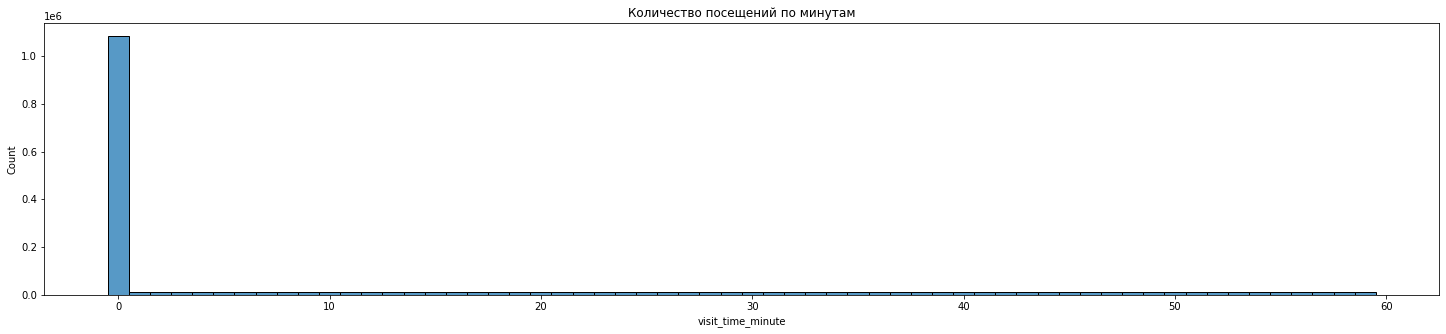

In [50]:
df_sessions['visit_time_minute'] = df_sessions['visit_time'].dt.minute
plt.figure(figsize=(25, 5))
sns.histplot(data=df_sessions, x='visit_time_minute', discrete=True)
plt.title('Количество посещений по минутам');

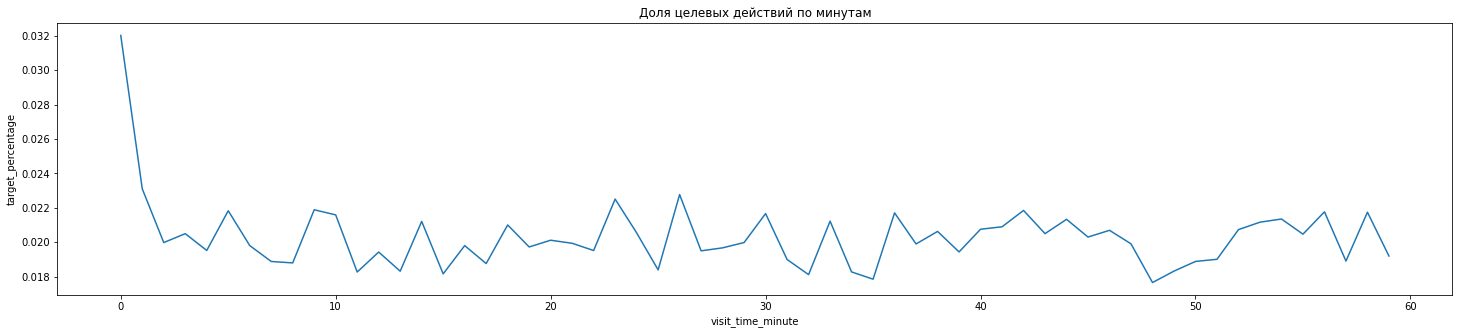

In [51]:
plt.figure(figsize=(25, 5))
target_by_minute = target_percentage(df_sessions, 'visit_time_minute', 
                                     percent=False, only_target=True)
sns.lineplot(data=target_by_minute)
plt.title('Доля целевых действий по минутам');

In [52]:
df_sessions['visit_time_minute_is_zero'] = df_sessions['visit_time_minute'] == 0
target_percentage(df_sessions, 'visit_time_minute_is_zero', index_name='0 минут')

,Количество объектов,Доля от общего числа,Процент целевых действий
0 минут,,,
True,1083333,58.24%,3.20%
False,776709,41.76%,2.01%


Полученные данные свидетельствуют о том, что наиболшее количество посещений приходится на начало каждого часа (00 минут) - более 58%, как и количество целевых действий - наибольшая доля указанных действий так же приходится на начало каждого часа - 3,2%.
Такое распределение данных весьма подозрительно и скорее всего является выбросом.
Начиная с первой минуты часа и до последнней осещение сайта и совершение целевых действий распределены более-менее равномерно.

### Выполним анализ посещений площадки в дневное и ночное время - для этих целей введем новый признак - `visit_time_night`.

In [53]:
df_sessions['visit_time_night'] = df_sessions['visit_time_hour'] < 9
print('Распределение целевых действий в ночное и дневное время:')
target_percentage(df_sessions, 'visit_time_night', index_name='Ночное время')

Распределение целевых действий в ночное и дневное время:


,Количество объектов,Доля от общего числа,Процент целевых действий
Ночное время,,,
False,1496535,80.46%,2.77%
True,363507,19.54%,2.42%


Полученные результаты показывют, что более 80% посещений приходится на дневное время, при этом совершение целевых действий не имеет значительных различий от врмени суток.

### Проведем анализ переменной `visit_number` - номер визита посетителя  

In [54]:
df_sessions['visit_number'].describe().apply(lambda x: f'{x:0.1f}')

count    1860042.0
mean           2.7
std           11.8
min            1.0
25%            1.0
50%            1.0
75%            2.0
max          564.0
Name: visit_number, dtype: object

Данные показывают, что максимальное число посещений составляет 564 раза, минимальное количество посещений 1 раз. В среднем каждый пользователь совершил 3 посещения.

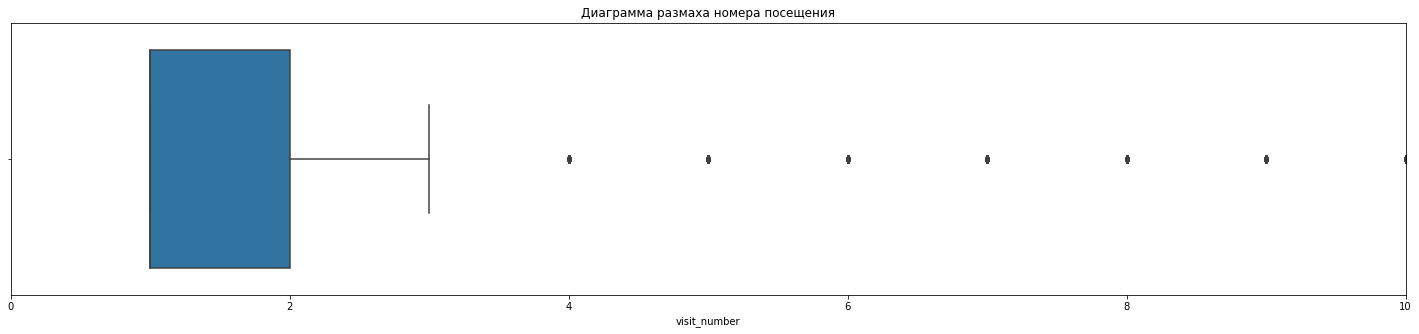

In [55]:
plt.figure(figsize=(25, 5))
sns.boxplot(data=df_sessions, x='visit_number')
plt.xlim(0, 10)
plt.title('Диаграмма размаха номера посещения');

График показывает, то имеет место быть значительное количество пользоватеей, которые посетили сайт 4 и более раз. Представляется возможным привести пользователей с количеством посещений от 4 и более к сопоставимому виду - примем все значения равными 4. При том выделим 4 группы посетителей с количеством посещений от 1 до 4 раз.

In [56]:
df_sessions['visit_number_no_outliers'] = df_sessions['visit_number'].apply(lambda x: x if x < 4 else 4)
print('Процент успешных сессий в зависимости от номера посещения: ')
target_percentage(df_sessions, 'visit_number_no_outliers', 
                  index_name='Номер посещения')

Процент успешных сессий в зависимости от номера посещения: 


,Количество объектов,Доля от общего числа,Процент целевых действий
Номер посещения,,,
4,166969,8.98%,4.37%
3,81068,4.36%,3.76%
2,235656,12.67%,3.23%
1,1376349,74.00%,2.35%


Данные таблицы показывают, что 74% псетителей заходили на сайт всего 1 раз, при этом процент целевых действий таких пользователей был минимальным. Пользователей, которые заходили на сайт 4 и более раз порядка 9% от общео числа пользователей. При этом процент целевых действий таки пользователей максимальный. В целом по данным таблицы прослеживается зависиость количества целевых действий пользователей от количества посещений сайта.

### Анализ признака `utm_source`- канал привлечения

In [57]:
print(f'Пропущенных значений в "utm_source": {df_sessions.utm_source.isna().sum()}')

Пропущенных значений в "utm_source": 97


In [58]:
n_unique = df_sessions.utm_source.nunique()
print(f'Количество уникальных значений в `utm_source`: {n_unique}')

Количество уникальных значений в `utm_source`: 293


In [59]:
df_sessions.utm_source.value_counts(dropna=False).head(20)

ZpYIoDJMcFzVoPFsHGJL    578290
fDLlAcSmythWSCVMvqvL    300575
kjsLglQLzykiRbcDiGcD    266354
MvfHsxITijuriZxsqZqt    186199
BHcvLfOaCWvWTykYqHVe    116320
bByPQxmDaMXgpHeypKSM    102287
QxAxdyPLuQMEcrdZWdWb     51415
aXQzDWsJuGXeBXexNHjc     31152
jaSOmLICuBzCFqHfBdRg     29241
RmEBuqrriAfAVsLQQmhk     28055
vFcAhRxLfOWKhvxjELkx     24413
PlbkrSYoHuZBWfYjYnfw     20792
hTjLvqNxGggkGnxSCaTm     14598
gDBGzjFKYabGgSPZvrDH     13565
fgymSoTvjKPEgaIJqsiH      9625
geDcueAOghDzHkGMmdOq      8680
ISrKoXQCxqqYvAZICvjs      8633
nSReTmyFtbSjlPrTKoaX      7285
SzZERoLMmrEUEhDaYcyN      6828
eLzNJHzPelJpEyBwMrKo      5386
Name: utm_source, dtype: int64

In [60]:
# Процент целевых действий для частых значений канала привлечения

def replace_rare(data: pd.Series, tolerance: float = 0.05) -> pd.Series:
    """Заменяет в колонке редкие значения на 'rare_other'. Редкими считаются 
    значения, доля появления которых не превышает `tolerance`. Также заполняет 
    пропуски значением '(nan)'.
    """

    data = data.copy()

    value_counts = data.value_counts(dropna=False)
    rare_values = value_counts[value_counts < (len(data) * tolerance)]
    rare_values = rare_values.index.tolist()
    
    data[data.isin(rare_values)] = 'rare_other'
    return data.fillna('(nan)')

print('Процент целевых действий для частых значений канала привлечения:')
df_sessions['utm_source_frequent'] = replace_rare(df_sessions.utm_source) # заполним пропуски и редкие значения 'rare_other' 
target_percentage(df_sessions, 'utm_source_frequent', 
                  index_name='Канал привлечения')

Процент целевых действий для частых значений канала привлечения:


,Количество объектов,Доля от общего числа,Процент целевых действий
Канал привлечения,,,
bByPQxmDaMXgpHeypKSM,102287,5.50%,5.43%
fDLlAcSmythWSCVMvqvL,300575,16.16%,3.50%
BHcvLfOaCWvWTykYqHVe,116320,6.25%,3.34%
ZpYIoDJMcFzVoPFsHGJL,578290,31.09%,2.77%
kjsLglQLzykiRbcDiGcD,266354,14.32%,2.36%
rare_other,310017,16.67%,1.87%
MvfHsxITijuriZxsqZqt,186199,10.01%,1.21%


Данные таблицы показывают, что процент целевых действий по каналам привлечения варьируется от 1,21% до 5,43%. При этом самый высокий процет целевых действий у менее популярного канала.

### Проведем анализ признака `utm_medium` - тип привлечения

In [61]:
# Возвращает, что пучтых значений нет.....
print(f'Количество пустых значений в `utm_medium`: {df_sessions.utm_medium.isna().sum()}')

Количество пустых значений в `utm_medium`: 0


In [62]:
# ...но при выводе количества уникальных значений, замечаем, что есть (none) и (not set), что также является пропусками!
df_sessions.utm_medium.value_counts(dropna=False).head(30)

banner             552272
cpc                434794
(none)             300575
cpm                242083
referral           152050
organic             63034
email               29240
push                28035
stories             10582
cpv                  8022
blogger_channel      8015
smartbanner          6794
blogger_stories      4312
cpa                  4279
tg                   4011
app                  2836
post                 2326
smm                  1985
outlook              1332
clicks                934
blogger_header        771
(not set)             480
info_text             343
sms                   239
landing               134
partner                97
fb_smm                 66
vk_smm                 65
link                   57
cbaafe                 47
Name: utm_medium, dtype: int64

In [63]:
def count_missings(data: pd.Series) -> int:
    """Возвращает количество пропущенных значений в pd.Series."""
    missing_values = ['(not set)', '(none)', '(NaN)', '(nan)']
    return data.isin(missing_values).sum() # missing_values - сохраним что будем считать пропусками

In [64]:
missings = count_missings(df_sessions.utm_medium)
print(f'Количество пустых значений в `utm_medium`: {missings}')

Количество пустых значений в `utm_medium`: 301055


In [65]:
n_unique = df_sessions.utm_medium.nunique()
print(f'Количество уникальных значений в `utm_medium`: {n_unique}')

Количество уникальных значений в `utm_medium`: 56


In [66]:
print('Процент целевых действий для частых значений типа привлечения:')
df_sessions['utm_medium_frequent'] = replace_rare(df_sessions['utm_medium'])
target_percentage(df_sessions, 'utm_medium_frequent', index_name='Тип привлечения')

Процент целевых действий для частых значений типа привлечения:


,Количество объектов,Доля от общего числа,Процент целевых действий
Тип привлечения,,,
referral,152050,8.17%,5.38%
(none),300575,16.16%,3.50%
banner,552272,29.69%,2.74%
rare_other,178268,9.58%,2.49%
cpc,434794,23.38%,2.19%
cpm,242083,13.01%,1.04%


Незаолненных значений в колонке `utm_medium` 301055 - значения типа (none) и  (not set). Уникальных значений - 56, что является невысоким показателем.  

  
Самые популярные типы трафика: banner, cpc, cpm, refferal.  

Для самых популярных значений `utm_medium` процент целевых действий находится в диапазоне от 1.04% до 5.38%.

### Выполним анализ переменной `utm_campaign` - рекламная кампания  

In [67]:
missings = df_sessions['utm_campaign'].isna().sum() / len(df_sessions)
miss = df_sessions['utm_campaign'].isna().sum()
print(f'Количество пропущенных значений в `utm_campaign`: {miss}, что составляет {missings:0.2%}')

Количество пропущенных значений в `utm_campaign`: 219603, что составляет 11.81%


In [68]:
n_unique = df_sessions['utm_campaign'].nunique()
print(f'Количество уникальных значений в `utm_campaign` = {n_unique}')

Количество уникальных значений в `utm_campaign` = 412


In [69]:
print('Процент целевых действий для самых частых значений рекламной кампании:')
df_sessions['utm_campaign_frequent'] = replace_rare(df_sessions['utm_campaign'], 0.05)
target_percentage(df_sessions, 'utm_campaign_frequent', 
                  index_name='Рекламная кампания')

Процент целевых действий для самых частых значений рекламной кампании:


,Количество объектов,Доля от общего числа,Процент целевых действий
Рекламная кампания,,,
LTuZkdKfxRGVceoWkVyg,463481,24.92%,4.10%
gecBYcKZCPMcVYdSSzKP,134042,7.21%,3.39%
(nan),219603,11.81%,3.27%
LEoPHuyFvzoNfnzGgfcd,324044,17.42%,2.88%
rare_other,471512,25.35%,1.65%
FTjNLDyTrXaWYgZymFkV,247360,13.30%,0.99%


Анализ переменной показал, что 12% значений в колонке пропущено (219,6 тыс. шт.).  
Уникальных значений признака составляет 412 шт., причём большая часть уникальных значений встречается в датасете очень редко. 

Для самых популярных значений процент целевых действий меняется от 0.99% до 4.10%.

### Выполним анализ переменной `utm_adcontent` 

In [70]:
missings = df_sessions['utm_adcontent'].isna().sum() / len(df_sessions)
miss = df_sessions['utm_adcontent'].isna().sum()
print(f'Количество пропущенных значений в `utm_adcontent`: {miss}, что составляет {missings:0.2%}')

Количество пропущенных значений в `utm_adcontent`: 335615, что составляет 18.04%


In [71]:
n_unique = df_sessions['utm_adcontent'].nunique()
print(f'Количество уникальных значений в `utm_adcontent` = {n_unique}')

Количество уникальных значений в `utm_adcontent` = 286


In [72]:
print('Процент целевых действий для частых значений utm_adcontent:')
df_sessions['utm_adcontent_frequent'] = replace_rare(df_sessions['utm_adcontent'])
target_percentage(df_sessions, 'utm_adcontent_frequent')

Процент целевых действий для частых значений utm_adcontent:


,Количество объектов,Доля от общего числа,Процент целевых действий
utm_adcontent_frequent,,,
JNHcPlZPxEMWDnRiyoBf,1006599,54.12%,3.37%
(nan),335615,18.04%,2.61%
vCIpmpaGBnIQhyYNkXqp,181048,9.73%,2.16%
xhoenQgDQsgfEPYNPwKO,113072,6.08%,1.12%
rare_other,223708,12.03%,1.08%


Анализ признака показал, что порядка 18% значений незаполнены (более 335 тыс. шт.).

Уникальных значений признака так же не так много - 286 шт

Для самых популярных значений признака доля целевых дейтвий находится в диапазоне от 1,08% до 3,37%.

### Проанализируем признак `utm_keyword` - ключевое слово.

In [73]:
missings = df_sessions['utm_keyword'].isna().sum() / len(df_sessions)
miss = df_sessions['utm_keyword'].isna().sum()
print(f'Количество пропущенных значений в `utm_keyword`: {miss}, что составляет {missings:0.2%}')

Количество пропущенных значений в `utm_keyword`: 1082061, что составляет 58.17%


In [74]:
n_unique = df_sessions['utm_keyword'].nunique()
print(f'Количество уникальных значений в `utm_keyword` = {n_unique}')

Количество уникальных значений в `utm_keyword` = 1219


In [75]:
print('Процент целевых действий для частых значений utm_keyword:')
df_sessions['utm_keyword_frequent'] = replace_rare(df_sessions['utm_keyword'], 0.01)
target_percentage(df_sessions, 'utm_keyword_frequent')

Процент целевых действий для частых значений utm_keyword:


,Количество объектов,Доля от общего числа,Процент целевых действий
utm_keyword_frequent,,,
(nan),1082061,58.17%,3.20%
puhZPIYqKXeFPaUviSjo,506819,27.25%,2.21%
rare_other,246921,13.28%,1.81%
aXQzDWsJuGXeBXexNHjc,24241,1.30%,0.30%


Анализ признака показал, что пропущено значений более 1082 тыс. шт. - 58% от общего количества. Данное обстоятельство позволяет предположить о малой ценности даннго признака для будущей модели.
Уникальных значений рассматриваемого признака 1219 шт.
Для самых популярных значений признака `utm_keyword` доля целевых дейтвий находится в диапазоне от 0,3% до 3,2%.

### Проанализируем признак `device_category` - тип устройства

In [76]:
missings = count_missings(df_sessions['device_category'])
print(f'Количество пропущенных значений в `device_category`: {missings}')

Количество пропущенных значений в `device_category`: 0


In [77]:
n_unique = df_sessions['device_category'].nunique()
print(f'Количество уникальных значений в `device_category` = {n_unique}')

Количество уникальных значений в `device_category` = 3


In [78]:
df_sessions['device_category'].value_counts(dropna=False)

mobile     1474871
desktop     366863
tablet       18308
Name: device_category, dtype: int64

In [79]:
print('Процент целевых действий по категориям устройств: ')
target_percentage(df_sessions, 'device_category', index_name='Тип устройства')

Процент целевых действий по категориям устройств: 


,Количество объектов,Доля от общего числа,Процент целевых действий
Тип устройства,,,
desktop,366863,19.72%,3.14%
mobile,1474871,79.29%,2.60%
tablet,18308,0.98%,2.31%


Проведенный анализ показал, что пропущенных значений нет, количество уникальных значений - 3 (компьютер, мобильный телефон, планшет).
Наибольший процент целевых действий пользователи совершают с использованием персонального компьютера.

### Выполним анализ переменной `device_os` - ОС устройства  

In [80]:
missings = (df_sessions['device_os'].isnull().sum())
print(f'Количество пропущенных значений в `device_os`: {missings}')

Количество пропущенных значений в `device_os`: 1070138


In [81]:
n_unique = df_sessions['device_os'].nunique()
print(f'Количество уникальных значений в `device_os` = {n_unique}')

Количество уникальных значений в `device_os` = 13


In [82]:
df_sessions['device_os'].value_counts(dropna=False)

NaN              1070138
Android           464054
iOS               207104
Windows            88307
Macintosh          24824
Linux               5120
(not set)            364
Chrome OS             83
BlackBerry            27
Tizen                  7
Samsung                4
Windows Phone          4
Firefox OS             3
Nokia                  3
Name: device_os, dtype: int64

In [83]:
print('Процент целевых действий для популярных ОС: ')
df_sessions['device_os_frequent'] = replace_rare(df_sessions['device_os'], 0.01)
target_percentage(df_sessions, 'device_os_frequent', index_name='ОС')

Процент целевых действий для популярных ОС: 


,Количество объектов,Доля от общего числа,Процент целевых действий
ОС,,,
(nan),1070138,57.53%,3.22%
Macintosh,24824,1.33%,3.11%
Android,464054,24.95%,2.04%
iOS,207104,11.13%,1.89%
Windows,88307,4.75%,1.85%
rare_other,5615,0.30%,1.60%


Анализ признака показал, что количество пропущенных значений велико - более 100 тыс., уникальных значений всего 13, при этом большая часть ОС устройств не идентифицирована.  
Наибольший процент целевых действий пользователи совершают с устройст с неопределенной ОС. 

### Анализ признака `device_brand` - марка устройства  

In [84]:
missings = (df_sessions['device_brand'].isna().sum()) / len(df_sessions)
print(f'Доля пропущенных значений в `device_brand`: {missings:0.2%}')

Доля пропущенных значений в `device_brand`: 19.74%


In [85]:
n_unique = df_sessions['device_brand'].nunique()
print(f'Количество уникальных значений в `device_brand` = {n_unique}')

Количество уникальных значений в `device_brand` = 205


In [86]:
df_sessions['device_brand'].value_counts(dropna=False).head(20)

Apple        551088
NaN          367178
Samsung      332194
Xiaomi       288367
Huawei       185853
Realme        19058
(not set)     17545
OPPO          13504
Vivo          11740
OnePlus        9965
Asus           7929
Nokia          7285
Sony           6459
ZTE            6365
Google         5150
Meizu          3750
Lenovo         3148
Blackview      2759
Tecno          2654
LG             2447
Name: device_brand, dtype: int64

In [87]:
print('Процент целевых действий для частых значений марки устройства:')
df_sessions['device_brand_frequent'] = replace_rare(df_sessions['device_brand'])
target_percentage(df_sessions, 'device_brand_frequent', 
                  index_name='Марка устройства')

Процент целевых действий для частых значений марки устройства:


,Количество объектов,Доля от общего числа,Процент целевых действий
Марка устройства,,,
(nan),367178,19.74%,3.14%
Samsung,332194,17.86%,3.03%
Apple,551088,29.63%,2.63%
Huawei,185853,9.99%,2.43%
rare_other,135362,7.28%,2.34%
Xiaomi,288367,15.50%,2.29%


Проведенный анализ показал, что уникальных значений принака 205 шт., доля пропущенных значений 19.7%.  
Наибольший процент целевых действий пользователи совершали с неопределенных устройств.

### Проанализируем переменную `device_model` - модель устройства  

In [88]:
missings = (df_sessions['device_model'].isna().sum())
print(f'Количество пропущенных значений в `device_model`: {missings}, что состаляет {missings/len(df_sessions): .2%}')

Количество пропущенных значений в `device_model`: 1843704, что состаляет  99.12%


In [89]:
n_unique = df_sessions['device_model'].nunique()
print(f'Количество уникальных значений в `device_model` = {n_unique}')

Количество уникальных значений в `device_model` = 104


In [90]:
df_sessions['device_model'].value_counts(dropna=False).head(20)

NaN                     1843704
AuMdmADEIoPXiWpTsBEj       9778
tWBQlsvNfHxRUjaPAfhd        653
cwMJxNXiWUgMUxGiCTPs        651
pTgAEPipQxDXCjPrJbHo        461
FJApgTrMAGHoxCxQVKws        372
tfPZFRbtlzEssBEesRwM        335
pcvPxfVFaAmhwFmvIeYd        325
aCLaTVQlHcXbUnQYQvIg        236
mzJXHtJPIOSHoHtgezIA        235
JAIKWwxRffFOXQcfGTVi        198
zFCiMWkbbAhTflrlLWnz        176
jXFxTkHxuiBKWOvUtsIa        170
mSVMBvlHFgftJaQAZEdp        152
AshpvdJdReafUzEMmWGr        141
IiVVIXFnNMwpBtuHILvS        130
DzXtLnggNbQSyyFLKlgY        118
QIRMJBHwssjlXzlheRfO        102
wsPZygnUifLMgkSEnWLj        102
qBRdfuuhOnnqwSqNiPOv        101
Name: device_model, dtype: int64

In [91]:
print('Распределение пропущенного и остальных значений device_model:')
df_sessions['device_model_frequent'] = replace_rare(df_sessions['device_model'], 0.01)
target_percentage(df_sessions, 'device_model_frequent')

Распределение пропущенного и остальных значений device_model:


,Количество объектов,Доля от общего числа,Процент целевых действий
device_model_frequent,,,
(nan),1843704,99.12%,2.71%
rare_other,16338,0.88%,2.09%


Проведенный анализ показал, что количество пропской в колонке составляет более 99%, что делает нецелесообразным использование данного признака в моделировании.

### Выполним анализ признака `device_screen_resolution` - разрешение экрана  


In [92]:
missings = count_missings(df_sessions['device_screen_resolution'])
print(f'Пропущенных значений в `device_screen_resolution`:', missings)

Пропущенных значений в `device_screen_resolution`: 8


In [93]:
df_sessions['device_screen_resolution'].value_counts().head(20)

414x896      169090
1920x1080    125768
375x812      117944
393x851      115454
375x667       93341
360x780       92182
360x800       80547
412x915       74744
360x640       70588
390x844       60827
393x873       52056
360x720       50603
360x760       50467
412x892       43944
428x926       40690
1536x864      37287
1366x768      34102
414x736       32631
1440x900      31036
412x846       25121
Name: device_screen_resolution, dtype: int64

In [94]:
missing_values = ['(not set)', '(none)', '(NaN)', '(nan)', '0x0']
missed_mask = df_sessions['device_screen_resolution'].isin(missing_values)
df_sessions[missed_mask]['device_screen_resolution'].value_counts(dropna=False)

0x0          11
(not set)     8
Name: device_screen_resolution, dtype: int64

In [95]:
n_unique = df_sessions['device_screen_resolution'].nunique()
print(f'Уникальных значений в `device_screen_resolution` = {n_unique}')

Уникальных значений в `device_screen_resolution` = 5039


Разобъём колонку на ширину и высоту - `device_screen_width` и `device_screen_height`.

In [96]:
# создаем split, кторый будест состоять из ширины и длины. Перед этим пропущенные значения заменим на '414x896' и разделим в "х" и сохраним как целочисленное значение
split = df_sessions['device_screen_resolution'].replace(missing_values, '414x896').str.split('x', expand=True).astype(int)
# создадим столбцы с шириной и длиной, куда занесем значения
df_sessions[['device_screen_width', 'device_screen_height']] = split


In [97]:
df_sessions[['device_screen_width', 'device_screen_height']].describe()

,device_screen_width,device_screen_height
count,1.860042e+06,1.860042e+06
mean,6.567073e+02,8.408794e+02
std,5.531421e+02,1.939526e+02
min,1.800000e+02,2.560000e+02
25%,3.600000e+02,7.600000e+02
50%,3.930000e+02,8.440000e+02
75%,4.280000e+02,8.960000e+02
max,5.924000e+03,2.000000e+04


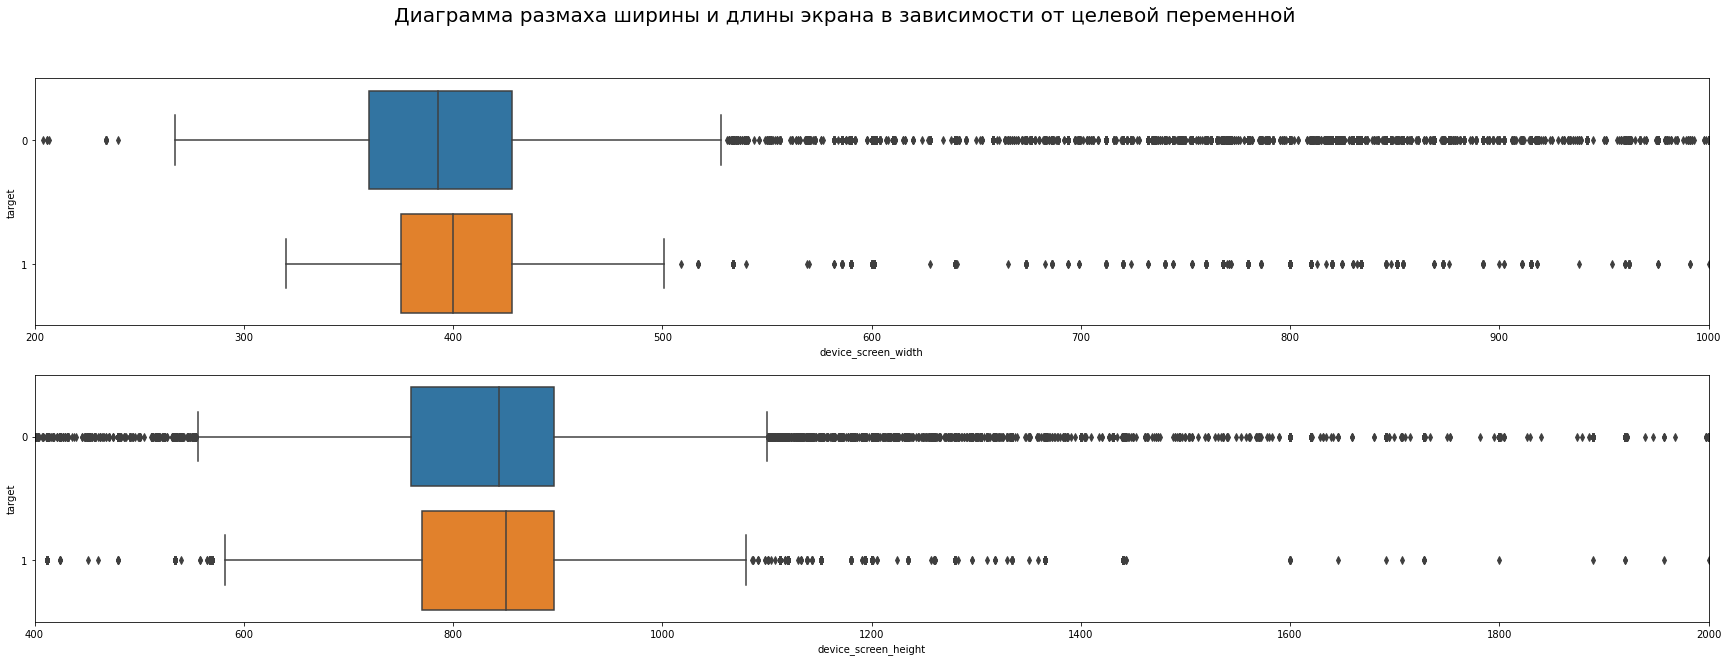

In [98]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(30, 10))

sns.boxplot(data=df_sessions, x='device_screen_width', 
            y='target', ax=ax1, orient='h')
sns.boxplot(data=df_sessions, x='device_screen_height', 
            y='target', ax=ax2, orient='h')

# ограничим показ выбросов
ax1.set_xlim(200, 1000)
ax2.set_xlim(400, 2000)

fig.suptitle(f'Диаграмма размаха ширины и длины экрана '
             f'в зависимости от целевой переменной', fontsize='20')
plt.show()

Создадим дополнительные признаки - площадь экрана `device_screen_area` и соотношение сторон `device_screen_ratio`.

In [99]:
df_sessions['device_screen_area'] = df_sessions['device_screen_width'] * df_sessions['device_screen_height']
df_sessions['device_screen_ratio'] = df_sessions['device_screen_width'] / df_sessions['device_screen_height']

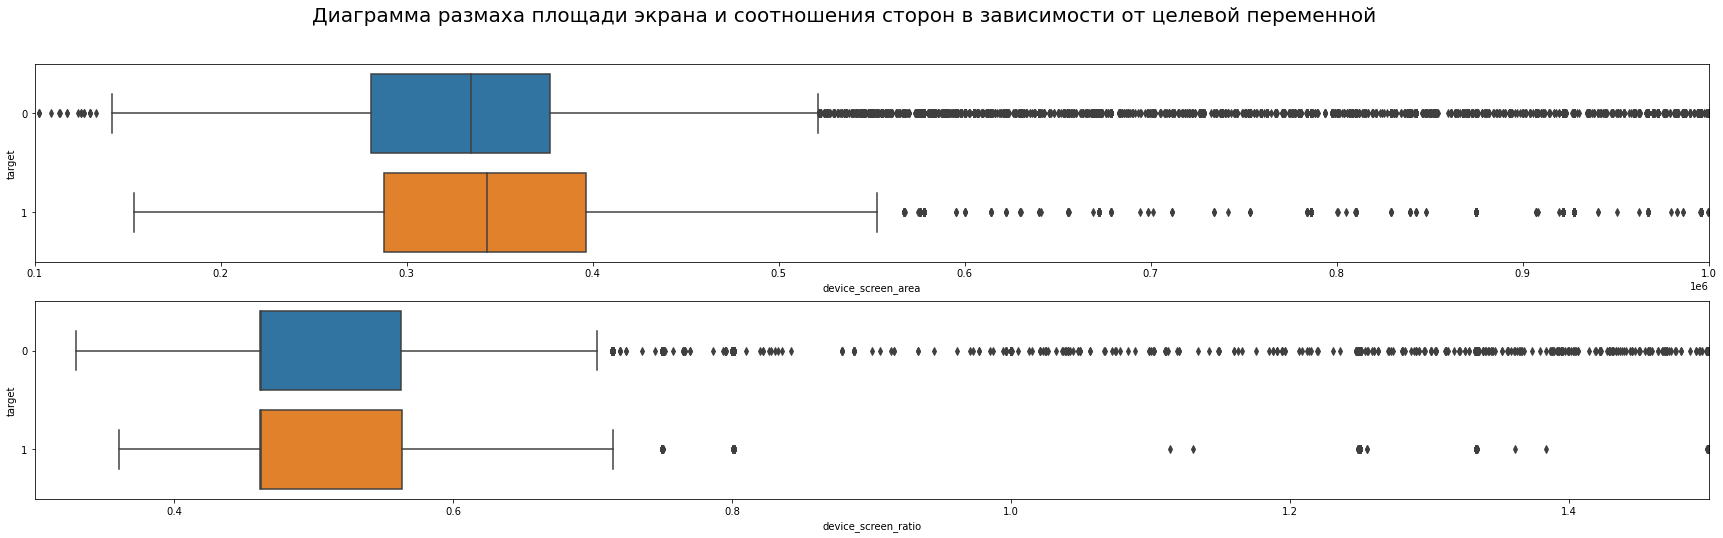

In [100]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(30, 8))

sns.boxplot(data=df_sessions, x='device_screen_area', 
            y='target', ax=ax1, orient='h')
sns.boxplot(data=df_sessions, x='device_screen_ratio', 
            y='target', ax=ax2, orient='h')

# ограничим показ выбросов
ax1.set_xlim(100_000, 1_000_000)
ax2.set_xlim(0.3, 1.5)

fig.suptitle(f'Диаграмма размаха площади экрана и соотношения сторон '
             f'в зависимости от целевой переменной', fontsize='20')
plt.show()

Проведенный анализ показывает, что пропущенных значений в колонке всего 19 (значения '0x0', '(not set)'). Самое часто встречающееся значение - 414x896. Пропуски были зменены на самое частое значение. Уникальных значений признака - 5039.  
Напрямую использовать признак не получится, но можно из него получить новые признаки, такие как: соотношение сторон, площадь, ширина и высота экрана.  
Целевая переменная не коррелирует ни с одним производным признаком. Судя по диаграммам размаха те, пользователи, у которых разрешение экрана выше, более склонны совершить целевое действие.  

### Проанализируем признак `device_browser` - браузер пользователя  

In [101]:
missed_mask = df_sessions['device_browser'].isin(missing_values)
missings = df_sessions[missed_mask]['device_browser'].value_counts(dropna=False)
print(f'Количество пропущенных значений в `device_browser`: {missings}')

Количество пропущенных значений в `device_browser`: (not set)    17
Name: device_browser, dtype: int64


In [102]:
n_unique = df_sessions['device_browser'].nunique()
print(f'Количество уникальных значений в `device_browser` = {n_unique}')

Количество уникальных значений в `device_browser` = 57


In [103]:
df_sessions['device_browser'].value_counts(dropna=False).head()

Chrome             1013436
Safari              478562
YaBrowser           133311
Safari (in-app)      69912
Android Webview      55369
Name: device_browser, dtype: int64

In [104]:
print('Процент целевых действий для самых популярных браузеров:')
df_sessions['device_browser_frequent'] = replace_rare(df_sessions['device_browser'], 
                                                      tolerance=0.01)
target_percentage(df_sessions, 'device_browser_frequent', index_name='Браузер')

Процент целевых действий для самых популярных браузеров:


,Количество объектов,Доля от общего числа,Процент целевых действий
Браузер,,,
rare_other,35326,1.90%,3.18%
YaBrowser,133311,7.17%,3.07%
Android Webview,55369,2.98%,2.81%
Safari,478562,25.73%,2.78%
Chrome,1013436,54.48%,2.68%
Samsung Internet,47309,2.54%,2.66%
Opera,26817,1.44%,2.09%
Safari (in-app),69912,3.76%,1.75%


Анализ признака показал, что незаполненых значений незначительное количество - 17 шт, уникальных значений признаков всего 57, но 88% из них встречаются редко.  
Наибольший процент целевых действий происходит чере Яндекс-браузер. В топе так же просмоторщик веб-страниц Андроид, Сафари и Хром.

### Проведем анализ признака `geo_country` - страна просмотра    

In [105]:
missed_mask = df_sessions['geo_country'].isin(missing_values)
missings = df_sessions[missed_mask]['geo_country'].value_counts(dropna=False)
print(f'Количество пропущенных значений в `geo_country`: {missings}')

Количество пропущенных значений в `geo_country`: (not set)    1146
Name: geo_country, dtype: int64


In [106]:
n_unique = df_sessions['geo_country'].nunique()
print(f'Количество уникальных значений в `geo_country` = {n_unique}')

Количество уникальных значений в `geo_country` = 166


In [107]:
df_sessions['geo_country'].value_counts(dropna=False).head(10)

Russia           1800565
United States      11784
Ukraine             9012
Ireland             4034
Belarus             3636
Sweden              2694
Kazakhstan          2279
Germany             2232
Turkey              1953
Netherlands         1549
Name: geo_country, dtype: int64

In [108]:
print('Процент целевых действий для стран с наибольшим посещением сайта:')
df_sessions['geo_country_frequent'] = replace_rare(df_sessions['geo_country'], 0.002)
target_percentage(df_sessions, 'geo_country_frequent', index_name='Страна')

Процент целевых действий для стран с наибольшим посещением сайта:


,Количество объектов,Доля от общего числа,Процент целевых действий
Страна,,,
Russia,1800565,96.80%,2.73%
rare_other,34647,1.86%,2.58%
Ukraine,9012,0.48%,2.21%
United States,11784,0.63%,0.54%
Ireland,4034,0.22%,0.02%


Посмотрим на распределение целевой переменной в России и за рубежом. Для этого создадим новый признак - `geo_country_is_russia`.


In [109]:
df_sessions['geo_country_is_russia'] = df_sessions['geo_country'] == 'Russia'

In [110]:
print('Процент целевых действий в России:')
target_percentage(df_sessions, 'geo_country_is_russia', index_name='Россия')

Процент целевых действий в России:


,Количество объектов,Доля от общего числа,Процент целевых действий
Россия,,,
True,1800565,96.80%,2.73%
False,59477,3.20%,1.95%


Результаты анализа показывают, что абсолютное большинство посетителей заходят на сайт из России и соответственно наибольший процент целевых действий совершается из России.  
 Всего уникальных значений признака 166, при этом пропущенных значений 1146.

### Рассмотрим признак `geo_city` - город  

In [111]:
missings = count_missings(df_sessions['geo_city']) /  len(df_sessions)
print(f'Доля пропущенных значений в `geo_city`: {missings:0.2%}')

Доля пропущенных значений в `geo_city`: 4.20%


In [112]:
n_unique = df_sessions['geo_city'].nunique()
print(f'Количество уникальных значений в `geo_city` = {n_unique}')

Количество уникальных значений в `geo_city` = 2548


In [113]:
df_sessions['geo_city'].value_counts(dropna=False).head(15)

Moscow              805329
Saint Petersburg    296788
(not set)            78172
Yekaterinburg        35788
Krasnodar            32243
Kazan                29531
Samara               24992
Nizhny Novgorod      22227
Ufa                  21679
Novosibirsk          21568
Krasnoyarsk          16346
Chelyabinsk          15951
Tula                 15814
Voronezh             13908
Rostov-on-Don        13886
Name: geo_city, dtype: int64

In [114]:
print('Процент целевых действий для городов с наибольшим посещением сайта:')
df_sessions['geo_city_frequent'] = replace_rare(df_sessions['geo_city'], 0.01)
target_percentage(df_sessions, 'geo_city_frequent', index_name='Город')

Процент целевых действий для городов с наибольшим посещением сайта:


,Количество объектов,Доля от общего числа,Процент целевых действий
Город,,,
Kazan,29531,1.59%,3.86%
Krasnodar,32243,1.73%,3.35%
Ufa,21679,1.17%,2.95%
Moscow,805329,43.30%,2.93%
Samara,24992,1.34%,2.91%
rare_other,491725,26.44%,2.53%
Nizhny Novgorod,22227,1.19%,2.51%
Yekaterinburg,35788,1.92%,2.48%
Saint Petersburg,296788,15.96%,2.40%


Анализ признака `geo_city` показал, что наибольшее количество посетителей сервиса из Москвы и Питера. Процент целефых действий пользователей в этих городах составляет 2,93% и 2,4% соответственно.  
Доля незаполненных значений признака составляет 4,2%, а общее количество уникальных значений 2548.

Введем новый признак, который консолидирует все города в Московской области, как наиболее перспективного региона - `geo_moscow_region`.  
Создадим список городов, входящих в состав Московской области - `moscow_region_cities`.

In [115]:
moscow_region_cities = [
    'Aprelevka', 'Balashikha', 'Chekhov', 'Chernogolovka', 'Dedovsk', 
    'Dmitrov', 'Dolgoprudny', 'Domodedovo', 'Dubna', 'Dzerzhinsky', 
    'Elektrogorsk', 'Elektrostal', 'Elektrougli', 'Fryazino', 'Golitsyno', 
    'Istra', 'Ivanteyevka', 'Kalininets', 'Kashira', 'Khimki', 'Khotkovo', 
    'Klimovsk', 'Klin', 'Kolomna', 'Korolyov', 'Kotelniki', 'Krasnoarmeysk', 
    'Krasnogorsk', 'Krasnoznamensk', 'Kubinka', 'Kurovskoye', 
    'Likino-Dulyovo', 'Lobnya', 'Losino-Petrovsky', 'Lukhovitsy', 
    'Lytkarino', 'Lyubertsy', 'Mozhaysk', 'Mytishchi', 'Naro-Fominsk', 
    'Noginsk', 'Odintsovo', 'Orekhovo-Zuyevo', 'Pavlovsky Posad', 'Podolsk', 
    'Protvino', 'Pushchino', 'Pushkino', 'Ramenskoye', 'Reutov', 'Ruza', 
    'Sergiyev Posad', 'Serpukhov', 'Shatura', 'Shchyolkovo', 
    'Solnechnogorsk', 'Staraya Kupavna', 'Stupino', 'Vidnoye', 
    'Volokolamsk', 'Voskresensk', 'Yakhroma', 'Yegoryevsk', 'Zvenigorod']

In [116]:
df_sessions['geo_moscow_region'] = df_sessions['geo_city'].copy()
df_sessions['geo_moscow_region'][df_sessions['geo_city'] != 'Moscow'] = 'other'
region_mask = df_sessions['geo_city'].isin(moscow_region_cities)
df_sessions['geo_moscow_region'][region_mask] = 'Moscow region'

C:\Users\V.Nikitin\AppData\Local\Temp\ipykernel_2280\3460515442.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sessions['geo_moscow_region'][df_sessions['geo_city'] != 'Moscow'] = 'other'
C:\Users\V.Nikitin\AppData\Local\Temp\ipykernel_2280\3460515442.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sessions['geo_moscow_region'][region_mask] = 'Moscow region'


In [117]:
print('Процент целевых действий в Московской области:')
target_percentage(df_sessions, 'geo_moscow_region', index_name='Москва или регион')

Процент целевых действий в Московской области:


,Количество объектов,Доля от общего числа,Процент целевых действий
Москва или регион,,,
Moscow,805329,43.30%,2.93%
Moscow region,101694,5.47%,2.87%
other,953019,51.24%,2.49%


Введем новый признак для больших городов - `geo_city_is_big`. Для этого создадим список крупных городов.

In [118]:
big_cities = ['Moscow', 'Saint Petersburg', 'Novosibirsk', 'Yekaterinburg', 
              'Kazan', 'Nizhny Novgorod', 'Chelyabinsk', 'Samara', 'Omsk', 
              'Rostov-on-Don', 'Ufa', 'Krasnoyarsk', 'Voronezh', 'Perm', 
              'Volgograd', 'Krasnodar', 'Saratov', 'Tyumen']


In [119]:
df_sessions['geo_city_is_big'] = df_sessions['geo_city'].isin(big_cities)
print('Процент целевых действий для больших городов:')
target_percentage(df_sessions, 'geo_city_is_big', index_name='Большой город')

Процент целевых действий для больших городов:


,Количество объектов,Доля от общего числа,Процент целевых действий
Большой город,,,
True,1380287,74.21%,2.78%
False,479755,25.79%,2.49%


Построим признак - расстояние от Москвы `geo_city_distance_from_moscow`. Расстояния получены с помощью библиотеки `geopy` и сохранены для удобства в словарь в переменную `distances_from_moscow`. Расстояния есть только для российских городов, для остальных расстояние -1.

In [120]:
distances_from_moscow = {
    'zlatoust': 1391.263586320666,
    'moscow': 0.0,
    'krasnoyarsk': 3336.039749777034,
    'saint petersburg': 636.1695135872066,
    'sochi': 1361.357154793485,
    'yaroslavl': 251.13992274208584,
    'mytishchi': 19.15256793901058,
    'novorossiysk': 1226.5566120134847,
    'balashikha': 22.57464380465976,
    'pushkino': 32.29150343512499,
    'vladivostok': 6434.301687239597,
    'alexandrov': 99.03461742181614,
    'astrakhan': 1272.5934764474214,
    'reutov': 15.066736856880723,
    'kazan': 721.4395898259049,
    'ulyanovsk': 704.8643503547661,
    'tula': 173.37597779851754,
    'yekaterinburg': 1421.8971980595,
    'rostov-on-don': 959.8830610946284,
    'samara': 856.8315253096929,
    'domodedovo': 36.1846810301295,
    'yoshkar-ola': 645.0905459206801,
    'chelyabinsk': 1498.8592485500628,
    'krasnogorsk': 19.128893627152596,
    'krasnodar': 1114.8111085097096,
    'lipetsk': 353.93468708196895,
    'nakhabino': 29.34753329618301,
    'kyzyl': 3669.160067257817,
    'ryazan': 184.0749867936237,
    'tyumen': 1716.8034849522674,
    'omsk': 2243.230614478407,
    'nizhny novgorod': 403.1271008941555,
    'irkutsk': 3997.3240242086913,
    'mezhdurechensk': 3186.977397404048,
    'stupino': 100.50298403934347,
    'serpukhov': 93.79639415363022,
    'saratov': 727.5243756615845,
    'grozny': 1498.6390016944135,
    'orenburg': 1230.997301228693,
    'surgut': 2143.5097426260527,
    'volgograd': 913.40653000604,
    'engels': 734.1820123219143,
    'fryazino': 35.68825436908673,
    'naberezhnye chelny': 926.5455187130812,
    'khabarovsk': 5955.703005291212,
    'ufa': 1168.153047105715,
    'novosibirsk': 2820.763592183317,
    'kirov': 793.5857281587636,
    'kotelniki': 18.556201509278427,
    'kaluga': 162.98501946171325,
    'vyborg': 758.2625638645857,
    'barnaul': 2943.257935404941,
    'tambov': 419.072146029825,
    'tver': 162.03184502252185,
    'korolyov': 23.240966914958825,
    'kostroma': 302.3271334606748,
    'zheleznodorozhny': 1051.3212963591216,
    'dolgoprudny': 21.451753870279653,
    'kursk': 456.3676328552856,
    'pyatigorsk': 1359.1346795165907,
    'khimki': 19.27787504978214,
    'dubna': 113.336078534706,
    'izhevsk': 970.8632565557036,
    'chita': 4752.38859817778,
    'cherkessk': 1319.672066231367,
    'blagoveshchensk': 5630.258195023883,
    'bryansk': 349.6394555186336,
    'voronezh': 467.015180857099,
    'kolomna': 103.33805649619023,
    'nalchik': 1430.5028996363571,
    'obninsk': 96.82910844583522,
    'belgorod': 577.7869858749181,
    'perm': 1170.262093684163,
    'severodvinsk': 989.3463180226084,
    'gatchina': 616.369780994091,
    'syktyvkar': 1007.3633668496318,
    'naro-fominsk': 68.51450800685191,
    'protvino': 101.15152863427636,
    'kamensk-uralsky': 1506.829417564834,
    'zhukovskiy': 600.4219593564324,
    'tomsk': 2655.7361007309364,
    'stavropol': 1278.9876969538484,
    'ivanteyevka': 31.051927448382365,
    'yegoryevsk': 98.37617987397816,
    'magnitogorsk': 1399.4447582737268,
    'vidnoye': 22.273670822552017,
    'abakan': 3386.4037130516103,
    'kraskovo': 24.96235703886392,
    'safonovo': 286.2924673657379,
    'shlisselburg': 608.2272247268463,
    'cherepovets': 376.65445395984784,
    'arkhangelsk': 992.6837722348444,
    'lyubertsy': 19.131687885364908,
    'vologda': 578.1169534315311,
    'petrozavodsk': 697.9721736505935,
    'oryol': 325.58358692835327,
    'odintsovo': 23.396555594006895,
    'voskresensk': 82.36561436203819,
    'almetyevsk': 934.756507490178,
    'veliky novgorod': 492.2434986334845,
    'kovrov': 240.34824684527445,
    'ramenskoye': 43.322630130479546,
    'berezniki': 1212.7987454012757,
    'shchyolkovo': 30.14037479489325,
    'novocheboksarsk': 617.6614496689281,
    'maykop': 1252.0417154745587,
    'nefteyugansk': 2101.016020281276,
    'tomilino': 587.5370629562508,
    'kaliningrad': 1091.7810203900708,
    'vladimir': 179.35415952478112,
    'velikiye luki': 446.4897914407206,
    'nakhodka': 6512.826751067336,
    'nizhnevartovsk': 2316.101568624056,
    'nevinnomyssk': 1274.9648982402225,
    'klin': 85.25341211585662,
    'uchaly': 1395.0694573085807,
    'novy urengoy': 2357.070596933191,
    'smolensk': 370.11957641629294,
    'dedovsk': 33.44282124708212,
    'sergiyev posad': 70.71201081392101,
    'vsevolozhsk': 629.8608377734972,
    'dmitrov': 66.48470950822428,
    'cheboksary': 602.6003537044186,
    'podolsk': 35.868186236649,
    'pervouralsk': 1380.892115200903,
    'anapa': 1207.7697317191653,
    'lytkarino': 26.171266900562145,
    'kopeysk': 1513.6217762611632,
    'tosno': 582.7586696635991,
    'norilsk': 2890.251515258955,
    'tolyatti': 799.8381096242144,
    'temryuk': 1165.3624515813908,
    'ussuriysk': 6381.347211888504,
    'istra': 50.88951924026617,
    'murmansk': 1491.035365952789,
    'ivanovo': 249.58733461631263,
    'verkhnyaya pyshma': 1418.646108882692,
    'maloyaroslavets': 110.21255938028736,
    'tikhvin': 496.9134080491585,
    'neryungri': 5028.977481470272,
    'kurgan': 1630.4830408964883,
    'novomoskovsk': 198.39912622251103,
    'kemerovo': 2996.19975700017,
    'volokolamsk': 108.56175176242488,
    'elektrostal': 51.84872232603937,
    'essentuki': 1354.1058476615915,
    'kislovodsk': 1365.9041690419383,
    'malakhovka': 26.99082254199157,
    'orekhovo-zuyevo': 85.6729405699771,
    'angarsk': 4178.283677448494,
    'chekhov': 68.44709881944979,
    'severomorsk': 1499.3047699096576,
    'leninsk-kuznetskiy': 3024.4663354351296,
    'satka': 1353.5254445419057,
    'dzerzhinsk': 368.59794417334047,
    'хомутово': 6668.791623791499,
    'penza': 556.0305682853448,
    'biysk': 3068.7132170237933,
    'novokuznetsk': 3127.6022996940287,
    'lobnya': 30.440525152635374,
    'sterlitamak': 1201.8214869231806,
    'naryan-mar': 1546.3123404691437,
    'kamyshin': 819.0343184384951,
    'artyom': 6430.381425066174,
    'yurga': 2914.0593434459674,
    'asbest': 1471.9556267379069,
    'sertolovo': 656.4737697387209,
    'staraya kupavna': 35.69475828769861,
    'volzhskiy': 915.5424228748903,
    'yuzhno-sakhalinsk': 6662.822265097304,
    'dzerzhinsky': 19.755817456584587,
    'krasnoznamensk': 40.16986859789947,
    'ulan-ude': 4432.539381037524,
    'zarechnyy': 606.0887567751221,
    'kostomuksha': 1057.376319264544,
    'povarovo': 50.52734489960697,
    'meleuz': 1226.2104294516412,
    'nazran': 1483.2725769944918,
    'klimovsk': 42.08840658931683,
    'stary oskol': 495.74079214243545,
    'vorkuta': 1891.6302759858595,
    'poltavskaya': 1155.8248883948718,
    'lukhovitsy': 125.0361461564636,
    'beloozyorskiy': 61.073850334859074,
    'elektrougli': 38.19286528690888,
    'chebarkul': 1438.8690266914327,
    'pskov': 611.6967383817062,
    'ukhta': 1249.5980588134028,
    'ruza': 89.5764906198789,
    'nizhny tagil': 1377.8498180844908,
    'yakutsk': 4901.163764820078,
    'khotkovo': 60.72433440755533,
    'elista': 1148.3051053640338,
    'bratsk': 3852.601801304402,
    'noginsk': 52.95761210648052,
    'makhachkala': 1587.5655360528883,
    'vladikavkaz': 1503.498930286972,
    'belovo': 3048.147193273616,
    'frolovo': 780.2333467253039,
    'petropavlovsk-kamchatskiy': 6798.018682170094,
    'borovichi': 370.0201002038788,
    'kratovo': 38.27502643887081,
    'prokopyevsk': 3097.586118228412,
    'seversk': 2878.478697347678,
    'rybinsk': 266.62620678639803,
    'pereslavl-zalessky': 133.65119287257676,
    'taganrog': 953.8988301108136,
    'novouralsk': 1387.9078797741597,
    'gelendzhik': 1245.0497234965765,
    'aramil': 1438.094504062841,
    'neftekamsk': 1037.9314586718494,
    'novotroitsk': 1457.0530345108157,
    'tuapse': 1300.1385167816816,
    'mozhaysk': 103.83921583291148,
    'sarov': 373.8154496798572,
    'kimry': 126.08756924425133,
    'kubinka': 61.218046614594186,
    'zheleznogorsk': 3391.850347906158,
    'saransk': 514.5759444962858,
    'dimitrovgrad': 784.9888159828704,
    'slavyansk-na-kubani': 1167.5855361519575,
    'tikhoretsk': 1114.786471927972,
    'salekhard': 1940.798233727196,
    'ostrov': 596.0147871697434,
    'kommunar': 609.0316563952802,
    'tsivilsk': 617.608810996026,
    'shakhty': 911.990910602426,
    'pechora': 1487.3071484483453,
    'svetogorsk': 784.6154471409538,
    'megion': 2289.965764352699,
    'bataysk': 969.330021045852,
    'kirishi': 530.8309526915012,
    'komsomolsk-on-amur': 6086.29642220532,
    'novocherkassk': 943.5609192173324,
    'chernogolovka': 55.75814822209252,
    'gorki-2': 727.7907922818495,
    'gus-khrustalny': 192.64146200083803,
    'berdsk': 2842.4371674583103,
    'lysva': 1251.2694243399262,
    'korsakov': 6693.46814234493,
    'sovetsk': 996.7695220314324,
    'aprelevka': 41.18219415362496,
    'semibratovo': 209.0654774418882,
    'pavlovsky posad': 64.94947986028654,
    'bor': 406.57781172305175,
    'magadan': 5696.766522816334,
    'kstovo': 413.3420040082879,
    'shatura': 122.7240473979108,
    'losino-petrovsky': 39.0856643165014,
    'yalutorovsk': 1770.7930860972722,
    'ust-ilimsk': 3824.762306477272,
    'pushchino': 101.94688109279312,
    'polysayevo': 3038.5975501321755,
    'prokhladny': 1409.5731328427237,
    'tobolsk': 1866.1259900513485,
    'birobidzhan': 6025.667074308183,
    'lipitsy': 488.33181946214216,
    'volgodonsk': 968.7193376964842,
    'yeysk': 1006.6702432800072,
    'golitsyno': 42.32796602639879,
    'miass': 1420.4111070245615,
    'yelets': 352.953027033769,
    'zvenigorod': 47.72843063332915,
    'selyatino': 47.81307831562977,
    'volkhov': 561.0120810417935,
    'krasnoarmeysk': 52.84859748189735,
    'apatity': 1335.0174311357218,
    'solnechnogorsk': 62.75797256121989,
    'buynaksk': 1591.6091181217846,
    'bolshoy kamen': 6459.6647658063575,
    'noyabrsk': 2258.5967649018207,
    'tynda': 5133.7148203026745,
    'nizhnekamsk': 891.351444472025,
    'usolye-sibirskoye': 4152.668391343766,
    'kingisepp': 673.0970220244146,
    'zelenodolsk': 682.4973369990087,
    'glazov': 950.3194914895024,
    'achinsk': 3216.780147934828,
    'rodniki': 295.0464136688749,
    'shelekhov': 4209.77264099612,
    'kaspiysk': 1601.679936799069,
    'birsk': 1127.659719672664,
    'nadym': 2157.8430358400265,
    'gorno-altaysk': 3143.3301534511943,
    'kolchugino': 3029.386251308493,
    'kushchyovskaya': 1034.055831067238,
    'yuzhnyy': 3482.931087966988,
    'armavir': 1221.3111343868295,
    'mozhga': 909.9695253925483,
    'vyksa': 292.00651478106886,
    'uzlovaya': 200.30676600029304,
    'rostov': 959.8830610946284,
    'kirovsk': 605.2671113612804,
    "ul'yanovka": 192.0411085381513,
    'novoaltaysk': 2950.9705068425405,
    'kamensk-shakhtinsky': 846.2139538784264,
    'ozersk': 1442.8560961441965,
    'elektrogorsk': 74.63716516619932,
    'arzamas': 394.35402804220274,
    'snezhinsk': 1438.9690430594771,
    'borisoglebsk': 569.9580301479704,
    'mirny': 4170.726504147512,
    'vyazniki': 287.308764186897,
    'enem': 1207.821030982559,
    'nyagan': 1734.888769945378,
    'khanty-mansiysk': 1906.792032820939,
    'monino': 37.715349372745926,
    'mineralnye vody': 1342.0944633137724,
    'verkhnyaya salda': 1413.7297090555912,
    'russkiy': 1213.062834379814,
    'revda': 1379.6717524046908,
    'lesnoy gorodok': 28.475504020539947,
    'argun': 1506.098028834171,
    'kyshtym': 1434.2595681626117,
    'salavat': 1210.078586205624,
    'tuchkovo': 74.30089302855156,
    'kumertau': 1226.5856038134475,
    'polevskoy': 1399.151300955637,
    'mikhaylovka': 734.9935677109922,
    'murom': 279.2759175366648,
    'kineshma': 335.5996758437128,
    'kandalaksha': 1299.3304879892798,
    'krasnouralsk': 1384.2334857967037,
    'torzhok': 217.4706587749375,
    'yuzhnouralsk': 1509.4408603749698,
    'shuya': 263.59454702063505,
    'serov': 1426.9672333775843,
    'sosnovy bor': 685.2323134899109,
    'shadrinsk': 1617.147870036188,
    'kotlas': 806.4754172091222,
    'novotitarovskaya': 1173.4741472213989,
    'balakovo': 787.8822091993675,
    '83709': 3202.813333769226,
    'azov': 968.9726699294038,
    'kirovo-chepetsk': 811.8571178014768,
    'rubtsovsk': 2872.4015656846614,
    'kirzhach': 90.62652039638547,
    'anadyr': 6213.777177759523,
    'khasavyurt': 1531.9145979750529,
    'beryozovsky': 1433.634294395171,
    'derbent': 1707.4033646935634,
    'dubovoe': 414.1453826358143,
    'vyazma': 217.54174988855237,
    'pyt-yakh': 2113.4245970564507,
    'semender': 1583.4934150903011,
    'nikolskoye': 598.9997361692872,
    'kashira': 107.13368440394626,
    'kizlyar': 1473.3798545362304,
    'zarinsk': 2997.181989822133,
    'konakovo': 119.1786549464336,
    'kurumoch': 839.7114992062343,
    'udomlya': 285.6169847200254,
    'minusinsk': 3402.637804653251,
    'kropotkin': 1166.2245607801617,
    'aleksandrovsk-sakhalinskiy': 6299.8823011927725,
    'pavlovo': 342.2607377444623,
    'otradny': 924.9037500182482,
    'aksay': 956.2965486068668,
    'balakhna': 381.1579987404556,
    'monchegorsk': 1379.666459717234,
    'kurchatov': 473.2883426264815,
    'orsk': 1466.0377255809008,
    'beloretsk': 1344.6724341902625,
    'vyshny volochyok': 276.9809306440123,
    'plastunovskaya': 1168.6851720045977,
    'nizhnyaya tura': 1375.9166273461458,
    'poronaysk': 6485.758764373887,
    'oktyabrsky': 1018.8184366705572,
    'shakhovskaya': 135.50534368151105,
    'kizilyurt': 1545.4401863233754,
    'chistopol': 821.3604105474976,
    'kansk': 3517.5408678268373,
    'inta': 1658.5575397677376,
    'novoshakhtinsk': 903.6507811060995,
    'kartaly': 1517.4593040784584,
    'kurovskoye': 84.3681700784244,
    'kuznetsk': 652.0791300259867,
    'rossosh': 631.8948563881265,
    'samarskoye': 990.9463636012208,
    'usinsk': 1560.1926768575506,
    'kanevskaya': 1079.414438120802,
    'lyuban': 552.7103608674508,
    'dalnegorsk': 6509.488452820776,
    'urus-martan': 1513.9438781256622,
    'votkinsk': 1018.7575282525304,
    'katav-ivanovsk': 1309.0842038516064,
    'olginka': 1287.7238993616631,
    'yakhroma': 60.64340421625101,
    'novokuybyshevsk': 851.6052629828683,
    'ishimbay': 1214.0401210017262,
    'sosnovoborsk': 3386.3759431879366,
    'gudermes': 1506.983332793841,
    'labytnangi': 1937.057017992013,
    'likino-dulyovo': 84.31241624220513,
    'lodeynoye pole': 604.1151265677914,
    'syzran': 760.0979681269697,
    'belaya kalitva': 870.3865327785855,
    'spassk-dalny': 6362.30839868133,
    'belorechensk': 1232.6961732990508,
    'sarapul': 1008.78232479936,
    'raduzhny': 2358.496974772968,
    'trudovoye': 1090.3401905593514,
    'kinel': 887.7664648811271,
    'korkino': 1505.8826336695265,
    'kiselyovsk': 3086.31280001039,
    'berezovka': 1087.264673590551,
    'goryachevodsky': 1360.7786042757737,
    'michurinsk': 369.2508261957532,
    'bobrovskiy': 322.39759418097685,
    'chegem': 1420.378254627167,
    'yelizovo': 6772.820421777107,
    '53425': 3202.813333769226,
    'тимофеевка': 1006.6834116656815,
    'ust-labinsk': 1180.6818380079214,
    'starokorsunskaya': 1196.1976393224706,
    'tarko-sale': 2388.9780271861964,
    'kachkanar': 1354.197212226372,
    'iskitim': 2858.9099151934147,
    'sibay': 1407.2647547506033,
    'vlasikha': 2933.2726322389262,
    '8756': 10.730176534095364,
    'agoi': 1294.7427424182354,
    'priozersk': 733.1545071632743,
    'bologoye': 321.9803937484453,
    'тарасовка': 1491.2541362483853,
    'beloyarsky': 1836.5384486488076,
    'ust-katav': 1302.724181677159,
    'kanash': 622.9255607421362,
    'dagestanskie ogni': 1698.208239037858,
    'belogorsk': 5631.125637486317,
    'labinsk': 1255.8319936717032,
    'lyskovo': 465.1306258788371,
    'afipsky': 1208.3956944522176,
    'starnikovo': 65.1332863630618,
    'juravskaia': 1139.1135698400817,
    'korenovsk': 1151.523891415271,
    'znamenskiy': 1194.8142115320263,
    'slavgorod': 2644.610086488067,
    'kungur': 1200.4961224183248,
    'gadzhiyevo': 1519.9109169685858,
    'shchyokino': 194.4698174383533,
    'nogliki': 6268.259965863986,
    '39404': 3202.813333769226,
    'lenina': 1199.0498830456509,
    'gaiduk': 1219.513851211696,
    '9992': 982.845979460969,
    'marks': 751.1509601828144,
    'kugesi': 606.0520067073529,
    'solikamsk': 1216.98913220201,
    'bryukhovetskaya': 1111.082927529371,
    'slavyanka': 6428.684709591151,
    '24130': 3202.813333769226,
    'menzelinsk': 970.9489283044122,
    'vysokaya gora': 724.5834162625722,
    'vanino': 6362.894335239535,
    'malysheva': 1467.3592923926346,
    'korzhevskiy': 1171.954752073123,
    'troitsk': 1538.140668806304,
    'nizhnebakanskaya': 1210.9986252672918,
    'plast': 1482.6858068116453,
    'gorodishche': 591.2765666147258,
    'osinovo': 736.6860205116334,
    'zavidovo': 353.2224718264869,
    'zarechny': 1465.4555186281548,
    'novaya adygeya': 1196.6866369650947,
    'kholmsk': 6621.858284986929,
    'asha': 1245.1907526999598,
    '14076': 3202.813333769226,
    'petrovskoye': 385.1673685384485,
    'chernyakhovsk': 1012.0952920550218,
    'salsk': 1067.2210501046166,
    'argayash': 1458.8443906207276,
    '13403': 1152.7191232199125,
    'bavly': 1006.55370599998,
    'beslan': 1482.7229051085862}


In [121]:
def get_distance_from_moscow(city: str) -> float:
    """Возвращает расстояние от города `city` до Москвы в километрах. 
    Для неизвестных и зарубежных городов возвращает -1.
    """

    return distances_from_moscow.get(str(city).lower(), -1.0)

In [122]:
df_sessions['geo_city_distance_from_moscow'] = df_sessions['geo_city'].apply(get_distance_from_moscow)

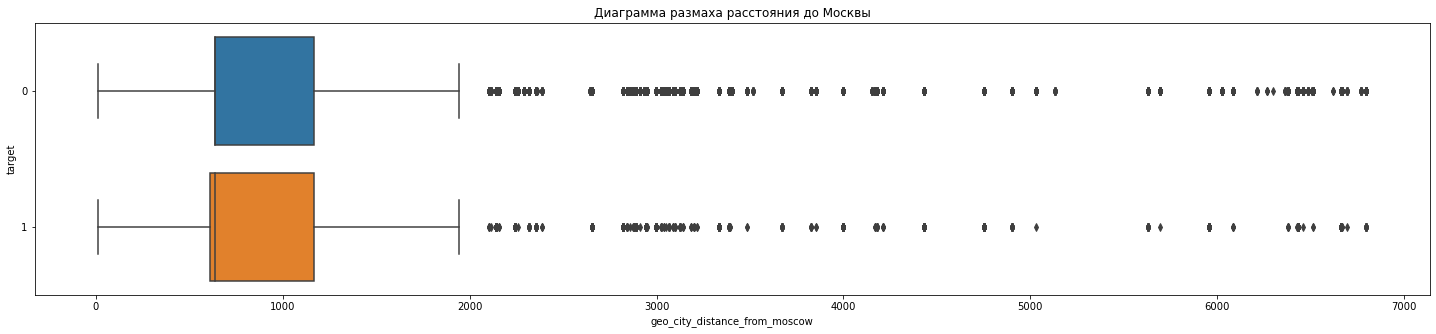

In [123]:
plt.figure(figsize=(25, 5))
positive_distances = df_sessions[df_sessions['geo_city_distance_from_moscow'] > 0]
sns.boxplot(data=positive_distances, x='geo_city_distance_from_moscow', 
            y='target', orient='h')
plt.title('Диаграмма размаха расстояния до Москвы');

Сгруппируем дистанцию по категория, чтобы оценить влияние расстояния на целевую переменную - `geo_city_distance_from_moscow_category`.

In [124]:
def get_distance_category(distance: float) -> str:
    """Возвращает категорию расстояния до Москвы."""

    if distance == -1: return 'no distance'
    elif distance == 0: return 'moscow'
    elif distance < 100: return '< 100 km'
    elif distance < 500: return '100-500 km'
    elif distance < 1000: return '500-1000 km'
    elif distance < 3000: return '1000-3000 km'
    else: return '>= 3000 km'

df_sessions['geo_city_distance_from_moscow_category'] = df_sessions['geo_city_distance_from_moscow'].apply(get_distance_category)

In [125]:
print('Распределение объектов по расстоянию до Москвы:')
target_percentage(df_sessions, 'geo_city_distance_from_moscow_category', 
                  index_name='Дистанция до Москвы')

Распределение объектов по расстоянию до Москвы:


,Количество объектов,Доля от общего числа,Процент целевых действий
Дистанция до Москвы,,,
moscow,805329,43.30%,2.93%
< 100 km,102673,5.52%,2.90%
1000-3000 km,229616,12.34%,2.77%
500-1000 km,421113,22.64%,2.54%
100-500 km,107529,5.78%,2.50%
>= 3000 km,61687,3.32%,2.21%
no distance,132095,7.10%,1.96%


Анализ принака `geo_city` показал:  
1. Пропущенных значений 4%.  
2. Уникальных значений - 2548, но наиболее крупные 'Moscow' и 'Saint Petersburg'. Дополнительно можно создать признак, включающий в себя населенные пункты в Московской области, так как на область и Москву приходится 5,8% целевых действий всех пользователей. Выделение крупных городов в зависимости от численности не целесообразно. При этом 43% сессий из Москвы, 5% из Московской области, а остальные из других городов. В Москве и области целевых действий больше, но не слишком значительно.  
3. Больший процент целевых действий в Москве и в пределах 100 км от Москвы.

## Взаимосвязь признаков

### Корреляции



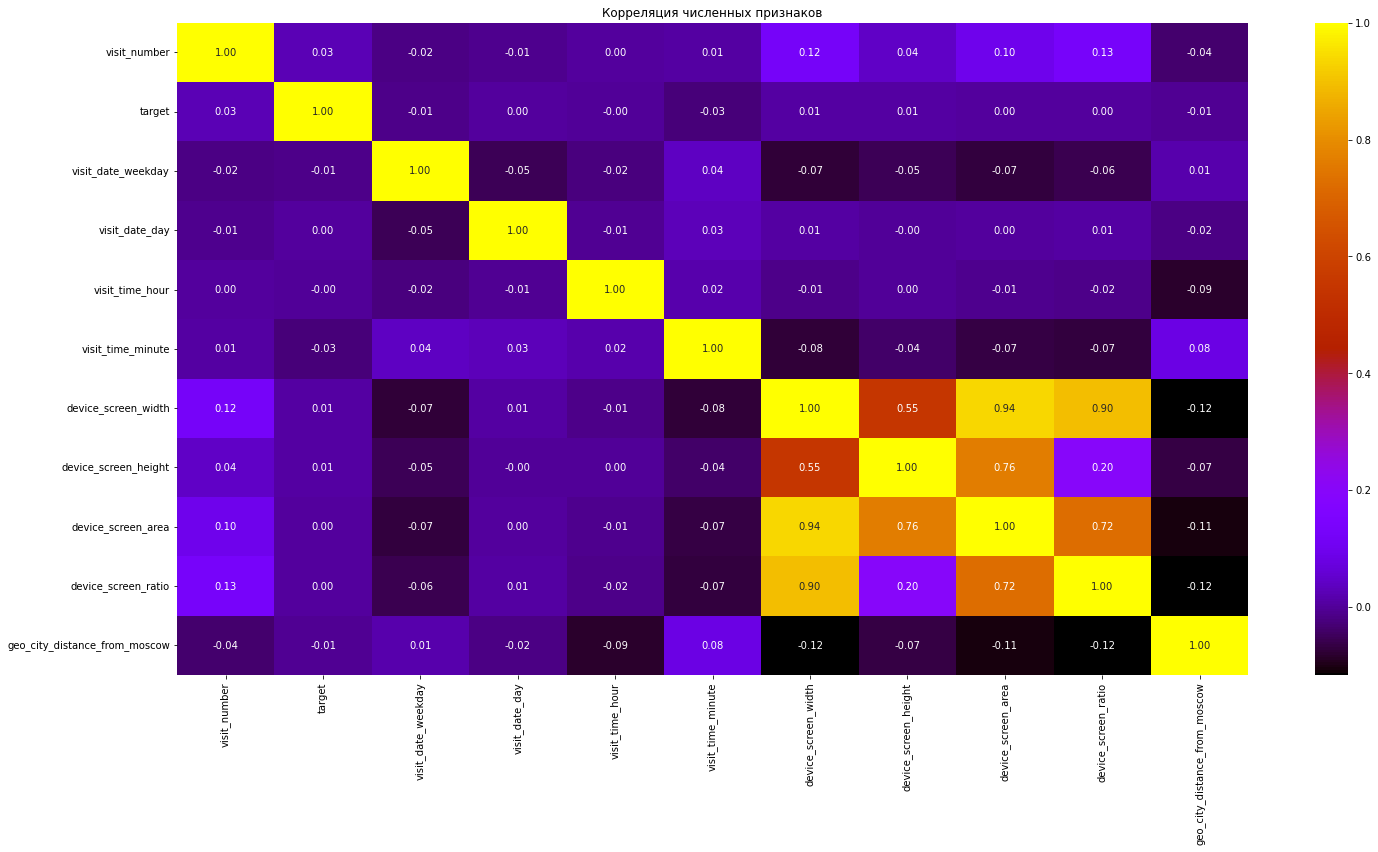

In [126]:
numerical_columns = [
    'visit_number', 'target', 'visit_date_weekday', 'visit_date_day', 
    'visit_time_hour', 'visit_time_minute', 'device_screen_width', 
    'device_screen_height', 'device_screen_area', 'device_screen_ratio', 
    'geo_city_distance_from_moscow']

plt.figure(figsize=(24,12))
sns.heatmap(df_sessions[numerical_columns].corr(), annot=True, fmt='0.2f', cmap= 'gnuplot')
plt.title('Корреляция численных признаков');

Поле корреляции показывает, что крепкая связь присутствует только у производных от `device_screen` признаков:  
- `device_screen_height`-`device_screen_width`, 
- `device_screen_area`-`device_screen_width`, 
- `device_screen_ratio`-`device_screen_width`.

### Псторная загрузка данных

Для файла `ga_hits.csv` нужно загрузить только колонки 'session_id' и 'event_action', так как остальные не используются.

In [127]:
df_sessions_new = pd.read_csv("D:\Final_Work\data\ga_sessions.csv", low_memory=False)
df_hits_new = pd.read_csv("D:\Final_Work\data\ga_hits.csv", 
                   usecols=['session_id', 'event_action'])

In [128]:
df_sessions_new.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 18 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   session_id                object
 1   client_id                 object
 2   visit_date                object
 3   visit_time                object
 4   visit_number              int64 
 5   utm_source                object
 6   utm_medium                object
 7   utm_campaign              object
 8   utm_adcontent             object
 9   utm_keyword               object
 10  device_category           object
 11  device_os                 object
 12  device_brand              object
 13  device_model              object
 14  device_screen_resolution  object
 15  device_browser            object
 16  geo_country               object
 17  geo_city                  object
dtypes: int64(1), object(17)
memory usage: 1.9 GB


In [129]:
df_hits_new.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15726470 entries, 0 to 15726469
Data columns (total 2 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   session_id    object
 1   event_action  object
dtypes: object(2)
memory usage: 2.5 GB


## Подготовка данных датафрейма

### Целевая переменная  

Целевая переменная считается положительной, если для сессии из `df_sessions_new` есть хотя бы одно целевое событие в `df_hits_new`. 

In [130]:
target_events = [
    'sub_car_request_submit_click', 'sub_car_claim_submit_click', 
    'sub_callback_submit_click', 'sub_call_number_click', 'sub_car_claim_click', 
    'sub_submit_success', 'sub_open_dialog_click']
df_hits_new['target'] = df_hits_new['event_action'].isin(target_events) # заполняет столбец hits['target'] 'True', если hits['event_action'] содержит целевую
is_target_event = df_hits_new.groupby('session_id')['target'].any().astype(int) # target группирует по id (session_id) и по столбцу 'target', то есть все одинаковые session_id собираются

In [131]:
df_hits_new['target']

0           False
1           False
2           False
3           False
4           False
            ...  
15726465    False
15726466    False
15726467    False
15726468    False
15726469    False
Name: target, Length: 15726470, dtype: bool

In [132]:
is_target_event

session_id
1000009318903347362.1632663668.1632663668    0
1000010177899156286.1635013443.1635013443    0
1000013386240115915.1635402956.1635402956    0
1000017303238376207.1623489300.1623489300    0
1000020580299877109.1624943350.1624943350    0
                                            ..
999960188766601545.1626816843.1626816843     0
99996598443387715.1626811203.1626811203      0
999966717128502952.1638428330.1638428330     0
999988617151873171.1623556243.1623556243     0
999989480451054428.1634311006.1634311006     0
Name: target, Length: 1734610, dtype: int32

In [133]:
target = pd.Series(is_target_event, index=df_sessions['session_id']).fillna(0.0) # Заполним пропуски 0,0
target.value_counts(dropna=False, normalize=True) 

0.0    0.97295
1.0    0.02705
Name: target, dtype: float64

Полученый результат совподает с ранее поллученым - всего целевых действий 2,7%

In [134]:
target

session_id
9055434745589932991.1637753792.1637753792    0.0
905544597018549464.1636867290.1636867290     0.0
9055446045651783499.1640648526.1640648526    0.0
9055447046360770272.1622255328.1622255328    0.0
9055447046360770272.1622255345.1622255345    0.0
                                            ... 
9055415581448263752.1640159305.1640159305    0.0
9055421130527858185.1622007305.1622007305    0.0
9055422955903931195.1636979515.1636979515    0.0
905543020766873816.1638189404.1638189404     0.0
9055430416266113553.1640968742.1640968742    0.0
Name: target, Length: 1860042, dtype: float64

In [135]:
del df_hits_new # удалим датафрейм за ненадобностью чтобы не занимал много памяти

### Заполнение пропусков  

Пропуски в колонке `device_screen_resolution` заполняем самым частым значением.  
Все остальные пропуски в колонках заполняем значением '(nan)'.

In [136]:
def fill_missings(data: pd.DataFrame) -> pd.DataFrame:
    """Заполняет пропущенные значения:
    * самым частым значением для `device_screen_resolution`;
    * значением '(nan)' во всех остальных случаях.
    """

    data = data.copy()

    if 'device_screen_resolution' in data.columns:
        # '414x896' - самое частое значение в 'device_screen_resolution'
        # согласно предварительному анализу данных
        data['device_screen_resolution'] = \
            data['device_screen_resolution'].replace(missing_values, '414x896')
    
    return data.fillna('(nan)')

### Генерация признаков

Создаётся множество дополнительных переменных: день недели и день месяца, является ли день выходным, час и минута посещения, ночью ли посещение, ширина, высота, площадь и соотношение экрана.

В том числе с дополнительными данными: является ли день празничным, является ли трафик органическим, из социальных ли сетей он, находится ли пользователь в большом городе или в московской области, расстояние до Москвы как численно, так и в виде категорий.

In [137]:
def distance_category(distance: float) -> str:
    """Возвращает категорию расстояния до Москвы."""

    if distance == -1: return 'no distance'
    elif distance == 0: return 'moscow'
    elif distance < 100: return '< 100 km'
    elif distance < 500: return '100-500 km'
    elif distance < 1000: return '500-1000 km'
    elif distance < 3000: return '1000-3000 km'
    else: return '>= 3000 km'

In [138]:
def create_features(data: pd.DataFrame) -> pd.DataFrame:
    """Создаёт новые признаки из существующих."""

    data = data.copy()
    
    # visit_date признаки 
    if 'visit_date' in data.columns:
        data['visit_date'] = data['visit_date'].astype('datetime64[ns]')
        data['visit_date_added_holiday'] = \
            data['visit_date'].isin(russian_holidays)
        # числовые признаки сделаем строго положительными 
        # для лучшей обработки на шаге с YeoJohnsonTransformer
        data['visit_date_weekday'] = data['visit_date'].dt.weekday + 1
        data['visit_date_weekend'] = data['visit_date'].dt.weekday > 4
        data['visit_date_day'] = data['visit_date'].dt.day + 1

    # visit_time признаки
    if 'visit_time' in data.columns:
        data['visit_time'] = data['visit_time'].astype('datetime64[ns]')
        data['visit_time_hour'] = data['visit_time'].dt.hour + 1
        data['visit_time_minute'] = data['visit_time'].dt.minute + 1
        data['visit_time_night'] = data['visit_time'].dt.hour < 9

    # utm_* признаки
    if 'utm_medium' in data.columns:
        data['utm_medium_added_is_organic'] = \
            data['utm_medium'].isin(organic_mediums)
    if 'utm_source' in data.columns: 
        data['utm_source_added_is_social'] = \
            data['utm_source'].isin(social_media_sources)
    
    # device_screen признаки
    if 'device_screen_resolution' in data.columns:
        name = 'device_screen_resolution'
        data[[name + '_width', name + '_height']] = \
            data[name].str.split('x', expand=True).astype(float)
        data[name + '_area'] = data[name + '_width'] * data[name + '_height']
        data[name + '_ratio'] = data[name + '_width'] / data[name + '_height']
        data[name + '_ratio_greater_1'] = data[name + '_ratio'] > 1

    # geo_city признаки 
    if 'geo_city' in data.columns:
        data['geo_city_added_is_moscow_region'] = \
            data['geo_city'].isin(moscow_region_cities)
        data['geo_city_added_is_big'] = data['geo_city'].isin(big_cities)
        data['geo_city_is_big_or_in_moscow_region'] = \
            data['geo_city_added_is_moscow_region'] \
            | data['geo_city_added_is_big']
        data['geo_city_added_distance_from_moscow'] = \
            data['geo_city'].apply(get_distance_from_moscow)
        data['geo_city_added_distance_from_moscow_category'] = \
            data['geo_city_added_distance_from_moscow'].apply(distance_category)

    return data

In [139]:
def set_index(data: pd.DataFrame, column: str = 'session_id') -> pd.DataFrame:
    """Устанавливает в качестве индекса датафрейма колонку `column`."""
    
    data = data.copy()

    if column in data.columns:
        data = data.set_index(column)
    
    return data

In [140]:
def converse_types(data: pd.DataFrame) -> pd.DataFrame:
    """Приводит типы переменных к float. В первую очередь 
    необходимо для преобразования bool значений.
    """

    return data.astype(float)

### Собираем пайплайн  

Пайплайн по подготовке данных состоит из 4 частей:  
1. Создание дополнительных признаков
2. Преобразование численных переменных
3. Преобразование категориальных переменных
4. Удаление лишних признаков

In [141]:
preprocessor = Pipeline(steps=[

    # Создание дополнительных признаков и
    # Приведение датафрейма к удобному виду 
    ('indexer', FunctionTransformer(set_index)), 
    ('imputer', FunctionTransformer(fill_missings)), 
    ('engineer', FunctionTransformer(create_features)), 
    ('dropper', DropFeatures(['client_id', 'visit_date', 'visit_time', 
                              'device_screen_resolution'])), 

    # Преобразования численных переменных
    ('normalization', YeoJohnsonTransformer()), 
    ('outlier_remover', Winsorizer()), 
    ('scaler', SklearnTransformerWrapper(StandardScaler())), 

    # Преобразования категориальных признаков
    ('rare_encoder', RareLabelEncoder(tol=0.05, replace_with='rare')), 
    ('onehot_encoder', OneHotEncoder(drop_last_binary=True)), 
    ('bool_converter', FunctionTransformer(converse_types)), 

    # Удаление дубликатов и коррелируемых признаков
    ('constant_dropper', DropConstantFeatures(tol=0.99)), 
    ('duplicated_dropper', DropDuplicateFeatures()), 
    ('correlated_dropper', DropCorrelatedFeatures(threshold=0.8)), 

    ])

## Моделирование

### Разделение данных  

Разделим данные на тренировочную, валидационную и тестовую выборки.  


In [142]:
TEST_SIZE = 200_000
RANDOM_SEED = 0

In [143]:
X, X_test, y, y_test = train_test_split(
    df_sessions_new, target, test_size=TEST_SIZE, 
    stratify=target, random_state=RANDOM_SEED)

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=TEST_SIZE, 
    stratify=y, random_state=RANDOM_SEED)

print(f'train shapes: {X_train.shape} {y_train.shape}')
print(f'valid shapes: {X_valid.shape} {y_valid.shape}')
print(f'test  shapes: {X_test.shape} {y_test.shape}')

train shapes: (1460042, 18) (1460042,)
valid shapes: (200000, 18) (200000,)
test  shapes: (200000, 18) (200000,)


### Препроцессинг данных  

Преобразуем тренировочные и валидационные данные с помощью построенного конвейера.

In [144]:
X_train

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
1056663,547332070992313735.1638727047.1638727047,127435678.1638727047,2021-12-05,20:57:27,1,ZpYIoDJMcFzVoPFsHGJL,banner,TmThBvoCcwkCZZUWACYq,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,NaN,428x926,Safari,Russia,Novotroitsk
1409550,7049980726847853060.1629809978.1629809978,1641451550.1629344260,2021-08-24,15:00:00,5,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,PkybGvWbaqORmxjNunqZ,NaN,mobile,NaN,Xiaomi,NaN,393x851,Chrome,Russia,Balashikha
739873,4064566220882386809.1639930788.1639930788,946355569.1639915385,2021-12-19,19:19:48,2,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Samsung,NaN,339x753,Chrome,Russia,Almetyevsk
62902,1033849280328168809.1631647080.1631647080,240711793.1631647081,2021-09-14,22:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,gecBYcKZCPMcVYdSSzKP,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Apple,NaN,414x896,Safari,Russia,Saint Petersburg
1297234,6544287746962620171.1638268683.1638268683,1523710728.1638268683,2021-11-30,13:38:03,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,NaN,393x851,Chrome,Russia,Moscow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1793000,8755082352522037809.1633552946.1633552946,2038451459.1633552945,2021-10-06,23:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Samsung,NaN,360x800,Chrome,Russia,Moscow
207261,1682284231298311525.1640424805.1640424805,391687320.1640424805,2021-12-25,12:33:25,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,NaN,375x812,Safari,Russia,Saint Petersburg
93412,1170303784354950884.1640345317.1640345317,272482583.1640345316,2021-12-24,14:28:37,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,desktop,Windows,NaN,NaN,1920x1080,Chrome,Russia,Moscow
1568591,7753976912353269271.1634047522.1634047522,1805363435.1634047511,2021-10-12,17:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,gecBYcKZCPMcVYdSSzKP,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Xiaomi,NaN,393x851,Chrome,Russia,Novosibirsk


In [145]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_valid_preprocessed = preprocessor.transform(X_valid)

print(f'X_train.shape = {X_train_preprocessed.shape}')

c:\Users\V.Nikitin\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1557: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(trans.var(axis=0))
c:\Users\V.Nikitin\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:2216: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
c:\Users\V.Nikitin\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:2217: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)
c:\Users\V.Nikitin\Anaconda3\lib\site-packages\feature_engine\encoding\rare_label.py:216: UserWarning: The number of unique categories for variable device_category is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
c:\Users\V.Nikitin\Anaconda3\lib\site-packages\feature_engine\encoding\rare_label.py:216: UserWarning: The number of unique categories for variable geo_city_added_distance_from_moscow_category is

X_train.shape = (1460042, 55)


### Выбор метрик  

Будем использовать в качестве основной метрики - `roc_auc`. Но также взглянем и на другие метрики: `accuracy`, `precision`, `recall`, `f1`.  

In [146]:
def find_best_threshold(
    y_true: pd.Series, 
    y_proba: pd.Series, 
    metriс_name: str = 'roc_auc', 
    iterations: int = 250, 
    learning_rate: float = 0.05
) -> float:
    """Находит лучший порог перевода вероятностей `y_proba` 
    в принадлежность к классу 1.
    """
    
    # Получение функции метрики, которую оптимизируем
    metrics = {'roc_auc': roc_auc_score, 'f1': f1_score, 
               'precision': precision_score, 'recall': recall_score}
    metric_function = metrics.get(metriс_name, accuracy_score)

    # Получение метрики
    def get_metric(threshold: float) -> float:
        prediction = (y_proba > threshold).astype(int)
        return metric_function(y_true, prediction)

    direction = -1
    shift = 0.25

    best_threshold = 0.5
    best_metric = get_metric(best_threshold)

    # На каждой итерации
    for i in range(iterations):

        # Меняем порог
        threshold = best_threshold + direction * shift
        shift *= (1 - learning_rate)
        metric = get_metric(threshold)

        # И проверяем, улучшилась ли метрика
        if metric > best_metric: 
            best_threshold = threshold
            best_metric = metric
        else: 
            direction *= -1
            
    return best_threshold

In [147]:
def print_metrics(
    model: BaseEstimator, 
    X: pd.DataFrame, 
    y: pd.Series, 
    threshold: Union[float, None] = None, 
    show_roc_curve: bool = False
) -> None:
    """Получает метрики бинарной классификации из модели `model` на данных 
    `X` и `y`. Если возможно, то через метод `predict_proba` с заданным 
    порогом перевода вероятностей в классы `threshold`, иначе через `predict`. 
    Если `threshold` равен None, автоматически найдёт лучший порог.  
    ---
    Метрики: roc_auc, accuracy, precision, recall, f1, confusion_matrix, 
    roc_curve.
    """

    # Получим предсказания, если возможно в виде вероятностей
    try: 
        probas = model.predict_proba(X)[:, 1]
    except AttributeError:
        prediction = model.predict(X)
        threshold = None
        probas = None
    else:
        threshold = threshold or find_best_threshold(y, probas, 'roc_auc')
        prediction = (probas > threshold).astype(int)

    # Распечатаем порог перевода вероятностей в классы
    if threshold is None:
        print("Порог перевода вероятностей в классы: не используется")
    else:
        print(f"Порог перевода вероятностей в классы: {threshold}")
        print(f"{roc_auc_score(y, probas)} - roc_auc на вероятностях")

    # Распечатаем однострочные метрики
    print()
    print(f"{roc_auc_score(y, prediction):0.8f} - roc_auc")
    print(f"{accuracy_score(y, prediction):0.8f} - accuracy")
    print(f"{precision_score(y, prediction):0.8f} - precision")
    print(f"{recall_score(y, prediction):0.8f} - recall")
    print(f"{f1_score(y, prediction):0.8f} - f1")

    # Распечатаем матрицу ошибок
    conf_mat = confusion_matrix(y, prediction)
    classes = model.classes_
    n_classes = len(classes)
    print()
    print("|".join(f"{i:^10}" for i in ["prediction"] + list(classes)))
    print(f"{'true label':^10}" + ("|" + " " * 10) * n_classes)
    print("-" * ((n_classes * 10) + n_classes + 10))
    for i in range(n_classes):
        print("|".join(f"{j:>10}" for j in [classes[i]] + list(conf_mat[i])))

    # Отобразим ROC-кривую
    if show_roc_curve:
        print()
        plt.figure(figsize=(7, 4))
        if probas is not None:
            plt.plot(*roc_curve(y_test, probas)[:2], 
                     c='r', label='on probability')
        plt.plot(*roc_curve(y_test, prediction)[:2], c='b', label='on class')
        plt.plot([0, 1], [0, 1], c='y', label='random', linestyle='dashed')
        plt.title('Receiver operating characteristic')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()

### Базовая модель  

Так как целевая переменная распределена неравномерно, то в качестве нулевой гипотизы можно выбрать стратегию, которая для каждой сессии предсказывает значение 0.  


In [148]:
# Обучим базовую модель 
baseline = DummyClassifier(strategy='constant', constant=0)
baseline.fit(X_train_preprocessed, y_train)

# И получим её метрики
print_metrics(baseline, X_valid_preprocessed, y_valid, 0.5)

Порог перевода вероятностей в классы: 0.5


0.5 - roc_auc на вероятностях

0.50000000 - roc_auc
0.97295000 - accuracy
0.00000000 - precision
0.00000000 - recall


c:\Users\V.Nikitin\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.00000000 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|    194590|         0
       1.0|      5410|         0


### Выбор модели  

Обучим несколько моделей, оценим на валидационной выборке и выберем лучшую, которую уже будем оптимизировать.

### Выбор модели  

Обучим несколько моделей, оценим на валидационной выборке и выберем лучшую, которую уже будем оптимизировать.

In [149]:
logreg = LogisticRegression(random_state=RANDOM_SEED)

In [150]:
%%time
logreg.fit(X_train_preprocessed, y_train)

CPU times: total: 1min 1s
Wall time: 16 s


c:\Users\V.Nikitin\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=0)

In [151]:
print_metrics(logreg, X_valid_preprocessed, y_valid)

Порог перевода вероятностей в классы: 0.5
0.668311987126067 - roc_auc на вероятностях

0.50000000 - roc_auc
0.97295000 - accuracy


c:\Users\V.Nikitin\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.00000000 - precision
0.00000000 - recall
0.00000000 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|    194590|         0
       1.0|      5410|         0


#### Метод опорных векторов

In [152]:
svc = LinearSVC(class_weight='balanced')

In [153]:
%%time
svc.fit(X_train_preprocessed, y_train);

CPU times: total: 11min 46s
Wall time: 11min 47s


c:\Users\V.Nikitin\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(class_weight='balanced')

In [154]:
print_metrics(svc, X_valid_preprocessed, y_valid)

Порог перевода вероятностей в классы: не используется

0.62058588 - roc_auc
0.62677000 - accuracy
0.04377965 - precision
0.61404806 - recall
0.08173207 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|    122032|     72558
       1.0|      2088|      3322


#### Нейронная сеть

In [155]:
mlp = MLPClassifier((32,), random_state=RANDOM_SEED)

In [156]:
%%time
mlp.fit(X_train_preprocessed, y_train);

CPU times: total: 7min 3s
Wall time: 1min 46s


MLPClassifier(hidden_layer_sizes=(32,), random_state=0)

In [157]:
print_metrics(mlp, X_valid_preprocessed, y_valid)

Порог перевода вероятностей в классы: 0.5
0.6982130825521674 - roc_auc на вероятностях

0.50000000 - roc_auc
0.97295000 - accuracy


c:\Users\V.Nikitin\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.00000000 - precision
0.00000000 - recall
0.00000000 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|    194590|         0
       1.0|      5410|         0


#### Байесовский классификатор

In [158]:
gaussnb = GaussianNB()

In [159]:
%%time
gaussnb.fit(X_train_preprocessed, y_train);

CPU times: total: 1.41 s
Wall time: 1.4 s


GaussianNB()

In [160]:
print_metrics(gaussnb, X_valid_preprocessed, y_valid)

Порог перевода вероятностей в классы: 0.05419511287276451
0.6458839700782317 - roc_auc на вероятностях

0.60928251 - roc_auc
0.56001500 - accuracy
0.03986940 - precision
0.66136784 - recall
0.07520520 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|    108425|     86165
       1.0|      1832|      3578


#### Дерево решений

In [161]:
tree = DecisionTreeClassifier(random_state=RANDOM_SEED)

In [162]:
%%time
tree.fit(X_train_preprocessed, y_train);

CPU times: total: 29.6 s
Wall time: 29.6 s


DecisionTreeClassifier(random_state=0)

In [163]:
print_metrics(tree, X_valid_preprocessed, y_valid)

Порог перевода вероятностей в классы: 0.033708156968674276
0.5204877305418407 - roc_auc на вероятностях

0.52080171 - roc_auc
0.93335000 - accuracy
0.05183341 - precision
0.08465804 - recall
0.06429875 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|    186212|      8378
       1.0|      4952|       458


#### Случайный лес

In [164]:
forest = RandomForestClassifier(random_state=RANDOM_SEED)

In [165]:
%%time
forest.fit(X_train_preprocessed, y_train);

CPU times: total: 8min 21s
Wall time: 8min 23s


RandomForestClassifier(random_state=0)

In [166]:
print_metrics(forest, X_valid_preprocessed, y_valid)

Порог перевода вероятностей в классы: 0.010218123817113232
0.6253519433580381 - roc_auc на вероятностях

0.59594638 - roc_auc
0.59998000 - accuracy
0.03952047 - precision
0.59168207 - recall
0.07409208 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|    116795|     77795
       1.0|      2209|      3201


#### Градиентный Бустинг

In [167]:
histboost = HistGradientBoostingClassifier(random_state=RANDOM_SEED)

In [168]:
%%time
histboost.fit(X_train_preprocessed, y_train);

CPU times: total: 3min 28s
Wall time: 32.8 s


HistGradientBoostingClassifier(random_state=0)

In [169]:
print_metrics(histboost, X_valid_preprocessed, y_valid)

Порог перевода вероятностей в классы: 0.02822602984682529
0.70696812360298 - roc_auc на вероятностях

0.64682393 - roc_auc
0.62957000 - accuracy
0.04742197 - precision
0.66506470 - recall
0.08853129 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|    122316|     72274
       1.0|      1812|      3598


#### XGBoost

In [170]:
xgboost = XGBClassifier()

In [171]:
%%time
xgboost.fit(X_train_preprocessed.values, y_train.values);

CPU times: total: 22min 44s
Wall time: 3min 10s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [172]:
print_metrics(xgboost, X_valid_preprocessed.values, y_valid.values)

Порог перевода вероятностей в классы: 0.02784477629170188
0.7107721766577036 - roc_auc на вероятностях

0.65178082 - roc_auc
0.63432000 - accuracy
0.04836085 - precision
0.67024030 - recall
0.09021247 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|    123238|     71352
       1.0|      1784|      3626


Даная модель продемонстировала наилучшие параметры в соответствии с условиями поставленной задачи. Представляется рациональным перейти к оценке данной модели.

## Оценка модели

Создаем новый конвейер с учетом выбранной модели.

In [173]:
final_pipeline = Pipeline(steps=[

    # Создание дополнительных признаков и
    # Приведение датафрейма к удобному виду 
    ('indexer', FunctionTransformer(set_index)), 
    ('imputer', FunctionTransformer(fill_missings)), 
    ('engineer', FunctionTransformer(create_features)), 
    ('dropper', DropFeatures(['client_id', 'visit_date', 'visit_time', 
                              'device_screen_resolution'])), 

    # Преобразования численных переменных
    ('normalization', YeoJohnsonTransformer()), 
    ('outlier_remover', Winsorizer()), 
    ('scaler', SklearnTransformerWrapper(StandardScaler())), 

    # Преобразования категориальных признаков
    ('rare_encoder', RareLabelEncoder(tol=0.047319, replace_with='rare')),
    ('onehot_encoder', OneHotEncoder(drop_last_binary=True)), 
    ('bool_converter', FunctionTransformer(converse_types)), 

    # Удаление дубликатов и коррелируемых признаков
    ('constant_dropper', DropConstantFeatures(tol=0.95579)), 
    ('duplicated_dropper', DropDuplicateFeatures()), 
    ('correlated_dropper', DropCorrelatedFeatures(threshold=0.8856)), 

    # Лучшая модель с оптимизированными гиперпараметрами
    ('model', xgboost), 
    
])

In [174]:
final_pipeline.fit(X, y);

c:\Users\V.Nikitin\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1557: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(trans.var(axis=0))
c:\Users\V.Nikitin\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:2216: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
c:\Users\V.Nikitin\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:2217: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)
c:\Users\V.Nikitin\Anaconda3\lib\site-packages\feature_engine\encoding\rare_label.py:216: UserWarning: The number of unique categories for variable device_category is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
c:\Users\V.Nikitin\Anaconda3\lib\site-packages\feature_engine\encoding\rare_label.py:216: UserWarning: The number of unique categories for variable geo_city_added_distance_from_moscow_category is

In [175]:
test_proba = final_pipeline.predict_proba(X_test)[:, 1]
best_threshold = find_best_threshold(y_test, test_proba)
test_prediction = (test_proba > best_threshold).astype(int)

print(f'Лучший порог перевода вероятностей в класс: {best_threshold}')

Лучший порог перевода вероятностей в класс: 0.02756581733121548


In [176]:
print(f'Метрики лучшей модели на обучающей выборке:')
print_metrics(final_pipeline, X, y, best_threshold)

Метрики лучшей модели на обучающей выборке:
Порог перевода вероятностей в классы: 0.02756581733121548
0.7455873208807363 - roc_auc на вероятностях

0.67437459 - roc_auc
0.63281592 - accuracy
0.05126783 - precision
0.71831017 - recall
0.09570492 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|   1018246|    596892
       1.0|     12649|     32255


In [177]:
print(f'Метрики лучшей модели на тестовой выборке:')
print_metrics(
    final_pipeline, X_test, y_test, best_threshold)

Метрики лучшей модели на тестовой выборке:
Порог перевода вероятностей в классы: 0.02756581733121548
0.7136699548099568 - roc_auc на вероятностях

0.65183750 - roc_auc
0.62918500 - accuracy
0.04806416 - precision
0.67578558 - recall
0.08974532 - f1

prediction|   0.0    |   1.0    
true label|          |          
--------------------------------
       0.0|    122181|     72409
       1.0|      1754|      3656


Целевая метрика `roc-auc=0.6518` (для пресказанных классов) выбранной модели больше 0.65, что соответствует поставленной цели.

### Обучение на всех данных

Для анализа обработки данных и важности признаков разобъём финальный конвейер на препроцессор и модель и обучим их на всех данных. А перед сохранением модели объединим обратно.

In [178]:
final_model = final_pipeline.named_steps['model']
final_preprocessor = final_pipeline.set_params(model=None)

In [179]:
sessions_preprocessed = final_preprocessor.fit_transform(df_sessions_new)

c:\Users\V.Nikitin\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1557: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(trans.var(axis=0))
c:\Users\V.Nikitin\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:2216: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
c:\Users\V.Nikitin\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:2217: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)
c:\Users\V.Nikitin\Anaconda3\lib\site-packages\feature_engine\encoding\rare_label.py:216: UserWarning: The number of unique categories for variable device_category is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
c:\Users\V.Nikitin\Anaconda3\lib\site-packages\feature_engine\encoding\rare_label.py:216: UserWarning: The number of unique categories for variable geo_city_added_distance_from_moscow_category is

In [180]:
final_model.fit(sessions_preprocessed, target);

### Результаты обработки данных

In [181]:
sessions_preprocessed.shape

(1860042, 58)

In [182]:
sessions_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1860042 entries, 9055434745589932991.1637753792.1637753792 to 9055430416266113553.1640968742.1640968742
Data columns (total 58 columns):
 #   Column                                                     Dtype  
---  ------                                                     -----  
 0   visit_number                                               float64
 1   visit_date_weekday                                         float64
 2   visit_date_weekend                                         float64
 3   visit_date_day                                             float64
 4   visit_time_hour                                            float64
 5   visit_time_minute                                          float64
 6   visit_time_night                                           float64
 7   utm_medium_added_is_organic                                float64
 8   utm_source_added_is_social                                 float64
 9   device_screen_resolut

In [183]:
print('Количество дубликатов:', sessions_preprocessed.duplicated().sum())

Количество дубликатов: 176667


In [184]:
print('Корреляция с целевой переменной:')
correlation = pd.concat([sessions_preprocessed, target], axis=1).corr()
correlation['target'].sort_values(ascending=False, key=abs).head(5)

Корреляция с целевой переменной:


target                                1.000000
utm_medium_added_is_organic           0.050813
utm_medium_referral                   0.049207
utm_adcontent_JNHcPlZPxEMWDnRiyoBf    0.044788
utm_source_bByPQxmDaMXgpHeypKSM       0.040561
Name: target, dtype: float64

In [185]:
feature_importance = pd.Series(
    data=final_model.feature_importances_, 
    index=sessions_preprocessed.columns)

In [186]:
original_columns = list(df_sessions_new.columns) + ['_added_']
column_importances = list()
for col in original_columns:
    imp = feature_importance[feature_importance.index.str.contains(col)].sum()
    column_importances.append(imp)

column_importances = pd.Series(column_importances, index=original_columns)
column_importances.sort_values(ascending=False, inplace=True)

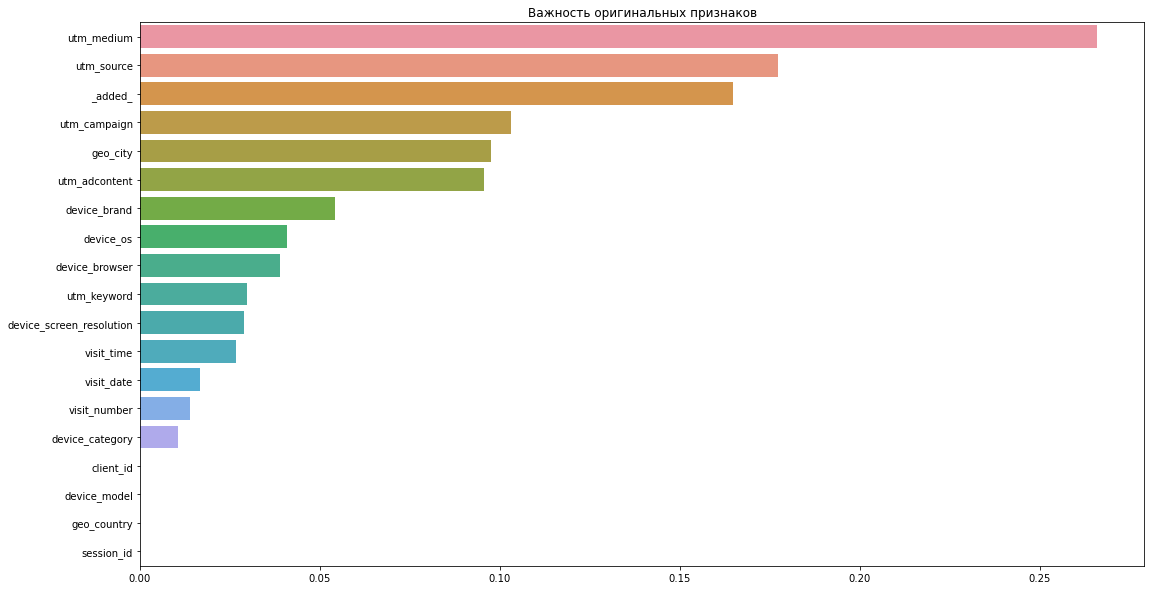

In [187]:
plt.figure(figsize=(18, 10))
sns.barplot(x=column_importances, y=column_importances.index, orient='h')
plt.title('Важность оригинальных признаков');

Самыми важными исходными признаками окзаались: размеры экрана, дата, время и номер посещения, город пользователя, а также признаки с дополнительными данными.

### Сохранение модели

In [188]:
# Объединим препроцессор и модель обратно

final_pipeline = final_preprocessor.set_params(model=final_model)

In [189]:
# Добавим метаданные для модели

metadata = {
    'name': 'SberAutopodpiska: target event prediction', 
    'descripton': ('Модель по предсказанию совершения пользователем одного из '
                   'целевых действий "Заказать звонок" или "Оставить заявку" '
                   'на сайте сервиса СберАвтоподписка.'), 
    'model_type': final_model.__class__.__name__, 
    'version': 'Not Detected :-)', 
    'training_datetime': datetime.now(), 
    'author': 'Alexander Vinogradov', 
    'threshold': best_threshold, 
    'metrics': {
        'roc_auc': roc_auc_score(y_test, test_proba), 
        'roc_auc_by_class': roc_auc_score(y_test, test_prediction),
        'accuracy': accuracy_score(y_test, test_prediction), 
        'precision': precision_score(y_test, test_prediction), 
        'recall': recall_score(y_test, test_prediction), 
        'f1': f1_score(y_test, test_prediction),
    }
}

final_pipeline.metadata = metadata

In [190]:
# Сохраним модель
models_folder = Path('.', 'models')
models_folder.mkdir(exist_ok=True)
filename = f'model_{datetime.now():%Y%m%d%H%M%S}.pkl'

with open(models_folder / filename, 'wb') as file:
    dill.dump(final_pipeline, file)

## Выводы


Для преобразования входных данных, со структурой как в файле `ga_sessions.csv`, в удобный для предсказания вид понадобилось четыре этапа:
1. Заполнение пропусков и генерация признаков. В том числе добавление новых данных, как-то органический трафик или расстояние до Москвы.
2. Преобразование численных переменных: нормализация и удаление выбросов.
3. Преобразование категориальных признаков. Основная сложность с ними была в многообразии редких уникальных значений. В итоге только самые популярные значения были закодированы методом one-hot.
4. Удаление дублирующих и коррелируемых признаков. Признаки могут коррелировать до 0.95, но именно с таким порогом финальная модель даёт лучший результат.

Было проверено 8 моделей с гиперпараметрами по умолчанию. 

В итоге в качестве лучшей модели был выбран `xgboost` по следующим причинам: 
+ Один из лучших показателей `roc_auc`.
+ Быстрое обучение. 
+ Модель интерпретируема, то есть можно получить показатели важности признаков.
+ Может предсказывать вероятность класса.


Качество модели по метрике `roc-auc` составляет **0.7107** (0.6518 при предсказании классов). Переобучения нет и цель проекта выполнена - `roc-auc` > 0.65.